# JFC #1 ESSD Paper Processing

<img src="crns4b.jpg" />

In [64]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import xarray
import os.path as path
import datetime as dt
import warnings
import cosmicsense as cs
import glob
import os
import copy
import matplotlib.animation as animation
import wradlib
from scipy.optimize import minimize_scalar, minimize
import scipy.stats as stats
from scipy import spatial
from matplotlib.colors import rgb2hex
from IPython.display import Image
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [65]:
warnings.simplefilter('once', RuntimeWarning)

In [66]:
# Display figures inline
%matplotlib inline

# Retrieve and inspect metadata

In [67]:
attrs = pd.read_csv("jfc1table.csv", sep=";")
attrs = attrs.set_index("id")
attrs["id"] = attrs.index
attrs.calstart = pd.to_datetime(attrs.calstart)
attrs.calend = pd.to_datetime(attrs.calend)
attrs

,institution,type,lon,lat,hasdata,hascal,calstart,calend,mincph,maxcph,id
id,,,,,,,,,,,
1,UP,CRS 2000-B,11.064395,47.825464,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1300,2100,1
2,UP,CRS 1000,11.061651,47.826620,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,600,1100,2
3,UP,CRS 1000,11.059494,47.831677,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,600,1100,3
4,UP,Lab-C,11.061457,47.823908,True,True,2019-05-28 09:45:00,2019-05-29 09:25:00,6000,9500,4
5,KIT,CRS 1000-B,11.063310,47.828752,True,True,2019-05-29 12:20:00,2019-05-31 08:35:00,800,1500,5
6,KIT,CRS 1000-B,11.064491,47.822520,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,800,1500,6
7,KIT,CRS 1000-B,11.059960,47.828184,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1000,1700,7
8,KIT,CRS 2000-B,11.060487,47.832478,True,True,2019-06-04 16:00:00,2019-06-05 11:53:00,1300,2500,8
9,UFZ,Styx Neutronica,11.066562,47.828935,False,True,2019-07-09 10:33:00,2019-07-10 13:08:00,-9999,-9999,9


In [68]:
locs = pd.read_excel("/media/x/cosmicsense/data/fendt/theta_sheet_merged.xlsx", sheet_name="locations")
locs = locs.set_index(locs.columns[0])

### Project geographic coordinates to UTM 32 N

In [69]:
wgs84 = wradlib.georef.epsg_to_osr(4326)
utm32n = wradlib.georef.epsg_to_osr(32632)

In [70]:
attrs["x"], attrs["y"] = wradlib.georef.reproject(attrs.lon, attrs.lat, projection_target=utm32n)
locs["x"], locs["y"] = wradlib.georef.reproject(locs.lon_adjusted, locs.lat_adjusted, projection_target=utm32n)

### Retrieve and reproject auxiliary geodata

In [243]:
# catchment
catdata, catlayer = wradlib.io.open_vector("/media/x/cosmicsense/data/fendt/data_v1/Elaborated/upperRottCatchment.shp")
catborders, keys = wradlib.georef.get_vector_coordinates(catlayer, source_srs=wgs84, dest_srs=utm32n)
# roads
roaddata, roadlayer = wradlib.io.open_vector("/media/x/cosmicsense/data/fendt/data_v1/Elaborated/FendtRoads.shp")
roads, keys = wradlib.georef.get_vector_coordinates(roadlayer, source_srs=wgs84, dest_srs=utm32n)
# water
waterdata, waterlayer = wradlib.io.open_vector("/media/x/cosmicsense/data/fendt/data_v1/Elaborated/upperRottStreams.shp")
water, keys = wradlib.georef.get_vector_coordinates(waterlayer, source_srs=wgs84, dest_srs=utm32n)
# SoilNet
snfile = "/media/x/cosmicsense/data/fendt/data_v1/Elaborated/soilnetNodesInfo.shp"
soilnetlatlon = cs.util.xy_from_pointshp(snfile)
soilnetxy = wradlib.georef.reproject(soilnetlatlon, projection_target=utm32n)
# Land use
lutdata, lutlayer = wradlib.io.open_vector("/media/x/cosmicsense/data/fendt/landuse/osm_landuse_selection.shp")
lut, lutkeys = wradlib.georef.get_vector_coordinates(lutlayer, key="fclass", source_srs=wgs84, dest_srs=utm32n)
# Buildings
builddata, buildlayer = wradlib.io.open_vector("/media/x/cosmicsense/data/fendt/data_v1/Elaborated/buildings_fendt.shp")
build, buildkeys = wradlib.georef.get_vector_coordinates(buildlayer, source_srs=wgs84, dest_srs=utm32n)
# Crops
cropdata, croplayer = wradlib.io.open_vector("/media/x/cosmicsense/data/fendt/data_v1/Elaborated/crops.shp")
crop, cropkeys = wradlib.georef.get_vector_coordinates(croplayer, source_srs=wgs84, dest_srs=utm32n)
# No trespassing
nogodata, nogolayer = wradlib.io.open_vector("/media/x/cosmicsense/git/misc/fendt/nogo.geojson")
nogo, nogokeys = wradlib.georef.get_vector_coordinates(nogolayer, source_srs=wgs84, dest_srs=utm32n)
nogo2data, nogo2layer = wradlib.io.open_vector("/media/x/cosmicsense/data/fendt/data_v1/Elaborated/nogo2.shp")
nogo2, nogo2keys = wradlib.georef.get_vector_coordinates(nogo2layer, source_srs=wgs84, dest_srs=utm32n)
# Climate station
meteox, meteoy = wradlib.georef.reproject(11.06073, 47.83289, projection_target=utm32n)

In [72]:
bbox = catlayer.GetExtent()
bboxxy = wradlib.georef.reproject([bbox[0], bbox[1]], [bbox[2], bbox[3]], projection_target=utm32n)

### Construct target grid

In [73]:
# Construct grid
delta = 10
xs = np.arange(bboxxy[0][0], bboxxy[0][1], delta)
ys = np.arange(bboxxy[1][0], bboxxy[1][1], delta)
xx, yy = np.meshgrid(xs, ys)
xxyy = np.array([xx.ravel(), yy.ravel()]).T
print("Grid shape:", xx.shape)

Grid shape: (143, 121)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


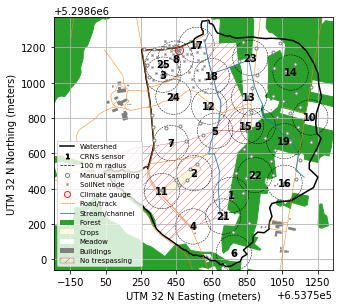

In [246]:
plt.rc('font', **{'size'   : 10})
fig, ax = plt.subplots(figsize=(5,5))
ax.set_aspect("equal")


plt.rcParams['hatch.color'] = "tab:red"
plt.rcParams['hatch.linewidth'] = 0.3
for i in range(len(nogo)):
    wradlib.vis.add_patches(ax, nogo[i], hatch="///", facecolors="None", edgecolor="tab:red", linewidth=0.3)
wradlib.vis.add_patches(ax, nogo2, hatch="///", facecolors="None", edgecolor="tab:red", linewidth=0.3)
    
wradlib.vis.add_patches(ax, crop, facecolors="cornsilk", edgecolor="None")

wradlib.vis.add_patches(ax, build, facecolors="grey", edgecolor="None")

for i in range(len(lut)):
    if lutkeys[i]=="forest":
        wradlib.vis.add_patches(ax, lut[i], color='tab:green')


for locid in locs.index:
    plt.plot(locs.loc[locid].x, locs.loc[locid].y, linewidth=0, marker="o", 
             markersize=3, mfc="white", mec="grey")

wradlib.vis.add_lines(ax, catborders, color='black', lw=1.5)
wradlib.vis.add_lines(ax, roads, color='tab:orange', lw=0.5)
wradlib.vis.add_lines(ax, water, color='tab:blue', lw=0.8)



for id in attrs.index:
    if attrs.loc[id].hasdata:
        mfc = "tab:red"
        mec = "black"
    else:
        #mfc="tab:red"
        mfc = "tab:red"
        mec = "black"
    #matplotlib.patches.Circle(xy, radius=5, **kwargs)
    circle = plt.Circle((attrs.loc[id].x, attrs.loc[id].y), 100, ls="dashed", facecolor="None", 
                        edgecolor="black", lw=0.5)
    ax.add_artist(circle)
    #plt.plot(attrs.loc[id].x, attrs.loc[id].y, linewidth=3, marker="o", markersize=6, mfc=mfc, mec=mec)
    #plt.annotate(str(id), xy=(attrs.loc[id,"x"]+10, attrs.loc[id,"y"]-10), ha='left', va='top', 
    #             color="tab:red", fontsize=12)
    plt.text(attrs.loc[id,"x"], attrs.loc[id,"y"], str(id), horizontalalignment="center", verticalalignment="center", 
                 color="black", fontsize=11, weight=550, stretch= 'ultra-condensed')#, weight="bold")
#plt.plot(xx, yy, linewidth=0, marker="o", ms=1, mfc="grey", mec="None")
plt.plot(soilnetxy[:,0], soilnetxy[:,1], linewidth=0, marker="x", ms=2, color="grey")#mfc="None", mec="black")
#for i in range(len(lut)):
#    if lutkeys[i]=="forest":
#        wradlib.vis.add_patches(ax, lut[i], color='tab:green')

plt.plot(meteox, meteoy, marker="o", mec="tab:red", mfc="None", ms=8)
    
plt.xlim(bboxxy[0][0]-300, bboxxy[0][1]+75)
plt.ylim(bboxxy[1][0], bboxxy[1][1])
plt.grid()
ax.ticklabel_format(axis="x", useOffset=653750)
ax.ticklabel_format(axis="y", useOffset=5298600)
plt.xlabel("UTM 32 N Easting (meters)")
plt.ylabel("UTM 32 N Northing (meters)")

legend_elements = [#plt.Line2D([0], [0], marker="o", ms=6,  mec="black", mfc="tab:olive", lw=0, label="CRNS"),
                   plt.Line2D([0], [0], lw=1.5, color="black", label="Watershed"),
                   plt.Line2D([0], [0], marker="$1$",  ms=5, color="black", lw=0, label="CRNS sensor"),
                   plt.Line2D([0], [0], lw=0.7, color="black", ls="--", label="100 m radius"), 
                   plt.Line2D([0], [0], marker="o", ms=4,  mec="grey", mfc="white", lw=0, label="Manual sampling"),
                   plt.Line2D([0], [0], marker="x", ms=2,  color="grey", lw=0, label="SoilNet node"),
                   plt.Line2D([0], [0], marker="o", mec="tab:red", mfc="None", ms=6, lw=0, label="Climate gauge"),
                   plt.Line2D([0], [0], lw=0.5, color="tab:orange", label="Road/track"),
                   plt.Line2D([0], [0], lw=0.8, color="tab:blue", label="Stream/channel"),
                   #plt.Line2D([0], [0], lw=6, color="tab:green", label="Forest"),
                   Patch(facecolor="tab:green", edgecolor="None", label="Forest"),
                   Patch(facecolor="cornsilk", edgecolor="None", label="Crops"),
                   Patch(facecolor="white", edgecolor="None", label="Meadow"),
                   Patch(facecolor="grey", edgecolor="None", label="Buildings"),
                   Patch(hatch="///", facecolor="None", edgecolor="tab:red", linewidth=0.3, label="No trespassing")]
_ = ax.legend(handles=legend_elements, fontsize=7, loc="lower left")

plt.savefig("datapaper/overviewmap.png", dpi=300, bbox_inches="tight")

In [75]:
attrs

,institution,type,lon,lat,hasdata,hascal,calstart,calend,mincph,maxcph,id,x,y
id,,,,,,,,,,,,,
1,UP,CRS 2000-B,11.064395,47.825464,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1300,2100,1,6.545101e+05,5.298965e+06
2,UP,CRS 1000,11.061651,47.826620,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,600,1100,2,6.543012e+05,5.299088e+06
3,UP,CRS 1000,11.059494,47.831677,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,600,1100,3,6.541248e+05,5.299646e+06
4,UP,Lab-C,11.061457,47.823908,True,True,2019-05-28 09:45:00,2019-05-29 09:25:00,6000,9500,4,6.542948e+05,5.298786e+06
5,KIT,CRS 1000-B,11.063310,47.828752,True,True,2019-05-29 12:20:00,2019-05-31 08:35:00,800,1500,5,6.544191e+05,5.299328e+06
6,KIT,CRS 1000-B,11.064491,47.822520,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,800,1500,6,6.545260e+05,5.298638e+06
7,KIT,CRS 1000-B,11.059960,47.828184,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1000,1700,7,6.541701e+05,5.299258e+06
8,KIT,CRS 2000-B,11.060487,47.832478,True,True,2019-06-04 16:00:00,2019-06-05 11:53:00,1300,2500,8,6.541967e+05,5.299737e+06
9,UFZ,Styx Neutronica,11.066562,47.828935,False,True,2019-07-09 10:33:00,2019-07-10 13:08:00,-9999,-9999,9,6.546619e+05,5.299355e+06


### Collecting meteo data

From DWD at Hohenpeißenberg:
- Precipitation: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/precipitation/recent/stundenwerte_RR_02290_akt.zip
- Temperature and humidity: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/air_temperature/recent/stundenwerte_TU_02290_akt.zip
- Pressure: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/pressure/recent/stundenwerte_P0_02290_akt.zip

In [76]:
f_prec = "/media/x/cosmicsense/data/fendt/dwd/stundenwerte_RR_02290_akt.txt"
prec = pd.read_csv(f_prec, sep=";", na_values=-999)
prec.columns = ["station_id", "datetime", "quality", "depth", "ind", "wrtr", "eor"]
prec.datetime = pd.to_datetime(prec.datetime, format="%Y%m%d%H")
prec = prec.set_index("datetime")

In [77]:
f_press = "/media/x/cosmicsense/data/fendt/dwd/stundenwerte_P0_02290_akt.txt"
press = pd.read_csv(f_press, sep=";", na_values=-999)
press.columns = ["station_id", "datetime", "quality", "p", "p0", "eor"]
press.datetime = pd.to_datetime(press.datetime, format="%Y%m%d%H")
press = press.set_index("datetime")

In [78]:
f_temphum = "/media/x/cosmicsense/data/fendt/dwd/stundenwerte_TU_02290_akt.txt"
temphum = pd.read_csv(f_temphum, sep=";", na_values=-999)
temphum.columns = ["station_id", "datetime", "quality", "temp2m", "relhum2m", "eor"]
temphum.datetime = pd.to_datetime(temphum.datetime, format="%Y%m%d%H")
temphum = temphum.set_index("datetime")

In [79]:
f_meteo = "/media/x/cosmicsense/data/fendt/meteo/2019_metDataDE-Fen.dat"
names = ["datetime","temp2m","press2m","relhum2m","windsp2m","winddir2m","swdownrad2m","lwdownrad2m","precip"]
meteo = pd.read_csv(f_meteo, sep=",", skiprows=2, names=names)
meteo.datetime = pd.to_datetime(meteo.datetime)
meteo = meteo.set_index("datetime")
meteo.index = meteo.index.tz_convert(None)

In [80]:
meteo["abshum2m"] = cs.conv.absolute_humidity(meteo.temp2m, meteo.relhum2m)
temphum["abshum2m"] = cs.conv.absolute_humidity(temphum.temp2m, temphum.relhum2m)

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


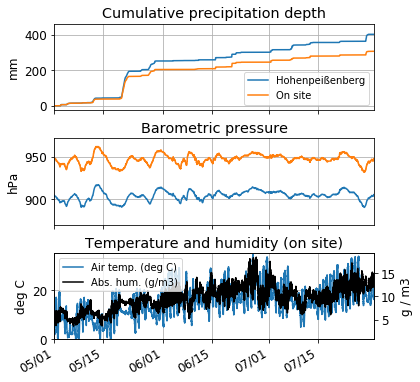

In [81]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=3, figsize=(6, 6), sharex=True)
ax = ax.ravel()

plt.sca(ax[0])
plt.plot(prec["2019-05-01":].index, prec["2019-05-01":].depth.cumsum(), label="Hohenpeißenberg")
plt.plot(meteo["2019-05-01":].index, meteo["2019-05-01":].precip.cumsum(), label="On site")
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#prec["2019-05-06":].depth.cumsum().plot()
plt.grid() 
plt.title("Cumulative precipitation depth")
plt.legend(fontsize=10)
plt.ylabel("mm")
xlim = dt.datetime(2019,5,1), dt.datetime(2019,7,31)

plt.sca(ax[1])
plt.plot(press.index, press.p0, label="Hohenpeißenberg")
plt.plot(meteo.index, meteo.press2m, label="On site")
plt.grid()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.title("Barometric pressure")
plt.ylabel("hPa")

plt.sca(ax[2])
#plt.plot(press["2019-05-06":].index, press["2019-05-06":].p0, label="Hohenpeißenberg")
templ = plt.plot(meteo.index, meteo.temp2m, label="Air temp. (deg C)")
#rehumpl = plt.plot(meteo.index, meteo.relhum2m, label="Rel. hum. (%)")
plt.grid()
plt.ylim(0,35)
plt.ylabel("deg C")
ax[2].set_xlim(xlim)
ax2 = ax[2].twinx()
abshumpl = plt.plot(meteo.index, meteo.abshum2m, color="black", label="Abs. hum. (g/m3)")
lns = templ+abshumpl
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, fontsize=10)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

plt.title("Temperature and humidity (on site)")
plt.ylabel("g / m3")
plt.tight_layout()


# ax = plt.subplot(414)
# templ = plt.plot(temphum["2019-05-06":].index, temphum["2019-05-06":].temp2m, label="Air temp. (deg C)")
# rehumpl = plt.plot(temphum["2019-05-06":].index, temphum["2019-05-06":].relhum2m, label="Rel. hum. (%)")
# plt.grid()
# plt.ylabel("deg C, %")
# ax2 = ax.twinx()
# abshumpl = plt.plot(temphum["2019-05-06":].index, temphum["2019-05-06":].abshum2m, color="black", 
#                     label="Abs. hum. (g/m3)")
# lns = templ+rehumpl+abshumpl
# labs = [l.get_label() for l in lns]
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
# plt.title("Temperature and humidity (Hohenpeißenberg)")
# plt.ylabel("g / m3")

#plt.tight_layout()
#ax.set_xlim(xlim)

fig.autofmt_xdate()
#plt.tight_layout()

plt.savefig("datapaper/meteo.png", dpi=150, bbox_inches="tight")

In [82]:
from eto import ETo
et_pm = ETo()
et_hg = ETo()

meteoH = meteo.resample("1H").mean()
meteoH.columns = ['T_mean', 'P', 'RH_mean', 'U_2', 'winddir2m', 'R_s', 'lwdownrad2m', 'precip', 'abshum2m']
meteoH = meteoH[['R_s', 'T_mean', 'P', 'RH_mean', 'U_2']]
meteoH.R_s = meteoH.R_s * 3600e-6 # to MJ/m2 at hourly freq
meteoH.P = meteoH.P / 10 # hPa to kPa 
#meteoH.RH_mean = meteoH.RH_mean / 100 # from %

meteoD = meteo.resample("1D").mean()
meteoD.columns = ['T_mean', 'P', 'RH_mean', 'U_2', 'winddir2m', 'R_s', 'lwdownrad2m', 'precip', 'abshum2m']
meteoD = meteoD[['R_s', 'T_mean', 'P', 'RH_mean', 'U_2']]
meteoD.R_s = meteoD.R_s * 86400e-6 # to MJ/m2 at daily freq
meteoD.P = meteoD.P / 10 # hPa to kPa
meteoD["T_min"] = meteo.temp2m.resample("1D").min() 
meteoD["T_max"] = meteo.temp2m.resample("1D").max() 


et_pm.param_est(meteoH, freq="H", z_msl=500, lat=47.83289, lon=11.06073, TZ_lon=15)
eto_pm = et_pm.eto_fao()
et_hg.param_est(meteoD, freq="D", z_msl=500, lat=47.83289, lon=11.06073, TZ_lon=15)
eto_hg = et_hg.eto_hargreaves()
eto_pmD = et_hg.eto_fao()

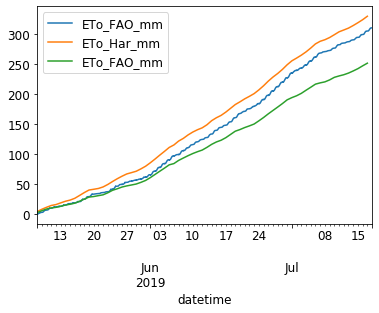

In [83]:
eto_pm["2019-05-08":"2019-07-17"].cumsum().plot()
eto_hg["2019-05-08":"2019-07-17"].cumsum().plot()
eto_pmD["2019-05-08":"2019-07-17"].cumsum().plot()
plt.legend()

## Read raw data

#### Read sensor data

In [84]:
fpath = "/media/x/cosmicsense/data/fendt/crns/"
crns = {}
for id in attrs.index:
    if not attrs.loc[id,"hasdata"]:
        continue
    df = pd.read_csv(path.join(fpath, "%d/%d_CRNS_merge.txt" % (id, id)), sep="\t")
    df.datetime = pd.to_datetime(df.datetime)
    df = df.set_index("datetime")
    if id==4:
        df["cph1"] = (df.counts1 + df.counts2) / cs.conv.s_to_h(df.nsecs1)
    else:
        df["cph1"] = df.counts1 / cs.conv.s_to_h(df.nsecs1)
        try:
            df["cph2"] = df.counts2 / cs.conv.s_to_h(df.nsecs2)
        except AttributeError:
            pass
    print(id, end=": ")
    if id==18:
        df = df["2019-05-09 00:00:00":]
    print("%s to %s" % (df.index[0], df.index[-1]) )
    crns[id] = df

1: 2019-05-09 09:59:00 to 2019-08-06 06:41:00
2: 2019-05-07 11:02:13 to 2019-08-06 08:46:30
3: 2019-05-07 08:37:25 to 2019-07-16 10:26:00
4: 2019-05-07 15:21:29 to 2019-07-16 13:19:00
5: 2019-05-03 08:53:04 to 2019-07-19 09:29:00
6: 2019-05-03 09:34:48 to 2019-07-19 07:05:00
7: 2019-05-13 14:54:00 to 2019-07-19 09:20:00
8: 2019-05-01 00:46:00 to 2019-07-22 11:46:00
14: 2019-05-08 06:45:44 to 2019-07-23 06:18:00
16: 2019-05-14 13:45:00 to 2019-07-16 16:31:00
17: 2019-05-15 14:14:46 to 2019-07-16 11:46:00
18: 2019-05-14 10:16:06 to 2019-07-17 08:24:00
19: 2019-05-14 12:45:49 to 2019-07-17 12:25:00
21: 2019-05-13 13:38:38 to 2019-07-16 04:17:00
22: 2019-05-13 15:24:44 to 2019-07-15 09:45:00
23: 2019-05-15 15:55:32 to 2019-07-17 04:19:00
24: 2019-05-15 15:09:58 to 2019-07-16 12:39:00
25: 2019-05-14 10:02:00 to 2019-07-19 09:01:00


In [85]:
min_dtime = np.min([crns[key].index[0] for key in crns.keys()])
max_dtime = np.max([crns[key].index[-1] for key in crns.keys()])
print(min_dtime, "-", max_dtime)
# Set max_dtime
max_dtime = dt.datetime(2019, 7, 23)

2019-05-01 00:46:00 - 2019-08-06 08:46:30


### Get calibrator data

In [86]:
cal = pd.read_csv("/home/maik/b2drop/cosmicsense/inbox/fendt/timeseries/crns/JFC-1-sd/20/cal.txt", sep="\t")
cal.datetime = pd.to_datetime(cal.datetime)
cal = cal.set_index("datetime")
# Accounting for counts in both tubes
cal["cph1"] = (cal.counts1 + cal.counts2) / cs.conv.s_to_h(cal.nsecs1)

#### Manually adjust calibration start and end in order to filter spurious counts

In [87]:
attrs["calstartadj"] = attrs.calstart
attrs["calendadj"] = attrs.calend
attrs.loc[22, "calstartadj"] = pd.Timestamp("2019-05-22 11:00:00")
attrs.loc[22, "calendadj"] = pd.Timestamp("2019-05-23 12:00:00")
attrs.loc[16, "calstartadj"] = pd.Timestamp("2019-05-23 12:45:00")
attrs.loc[4, "calstartadj"] = pd.Timestamp("2019-05-28 15:45:00")
attrs.loc[24, "calstartadj"] = pd.Timestamp("2019-06-26 17:00:00")
attrs.loc[18, "calstartadj"] = pd.Timestamp("2019-06-27 18:10:00")
attrs.loc[13, "calstartadj"] = pd.Timestamp("2019-07-03 09:20:00")
attrs.loc[15, "calstartadj"] = pd.Timestamp("2019-07-04 14:20:00")
attrs.loc[9, "calstartadj"] = pd.Timestamp("2019-07-09 11:20:00")
attrs.loc[17, "calstartadj"] = pd.Timestamp("2019-07-10 14:00:00")

In [88]:
cal["id"] = -9999
for id in attrs[attrs.hascal].id:
    cal.loc[attrs.loc[id,"calstartadj"]:attrs.loc[id,"calendadj"], "id"] = id

In [89]:
calavgcph = cal.groupby('id', as_index=False)['cph1'].mean()

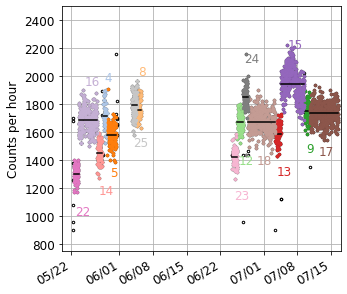

In [90]:
plt.rc('font', **{'size'   : 12})
colors = plt.cm.tab20(range(len(calavgcph)))
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
plt.plot(cal.index, cal.cph1, linewidth=0, marker=".", color="black", mfc="None", ms=5, label="unacc.")
plt.grid()
plt.xlim(dt.datetime(2019,5,20), dt.datetime(2019,7,17))
plt.ylim(750, 2500)
for i,id in enumerate(calavgcph.id):
    if not id==-9999:
        #start = attrs.loc[id,"calstartadj"]
        #end = attrs.loc[id,"calendadj"]
        #tmp = cal[start:end]
        plt.plot(cal.loc[cal.id==id].index, cal[cal.id==id].cph1, linewidth=0, marker=".", ms=5, color=colors[i], label=str(id))
        #plt.plot(tmp.loc[cal.id==id].index, tmp.loc[cal.id==id].cph1, linewidth=0, marker=".", ms=8, color=colors[i], label=str(id))
        plt.plot(attrs.loc[id,["calstartadj", "calendadj"]], np.repeat(calavgcph[calavgcph.id==id].cph1, 2), color="black", label="_tmp")
        startcal, endcal = attrs.loc[id,["calstartadj", "calendadj"]]
        plottime = startcal + 0.3*(endcal - startcal)
        if id in [16, 4, 8, 24, 15]:
            addval = 250
        else:
            addval = -300
        plt.text(plottime, calavgcph[calavgcph.id==id].cph1+addval, str(id), color=colors[i])
#plt.legend(ncol=6, columnspacing=0.001)
plt.ylabel("Counts per hour")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

fig.autofmt_xdate()

plt.savefig("calibrator.png", dpi=150, bbox_inches="tight")

In [91]:
(endcal - startcal)/2

Timedelta('0 days 12:54:00')

## Filter spurious signals

Some probes are affected by spurious count rates. In order to keep useful parts of the signal, a pragmatic/heuristic filtering approach is applied which could be refined later:

1. Remove entirely unrealisticly count rates for specific probes (`mincph`, `maxcph`)
2. Remove count rates from spuriously short count intervals (`mininterv`)
3. After that, there are still spurious count rates.In order to detect these, we compute the maximum count rates over periods of six hours, and then apply a 24-hour-median filter to these 6-hour-maxima. That way, we try to truncate spurios peaks. In order to prevent too aggressive filtering, we add a `buffer` of the median count rates over a period of 24 hours.
4. We then interpolate this upper limit filter to the original timestamp values and use it to remove high values.
5. We remove unrealisticly low count rates (`mincph`), and than apply the same approach (points 3-4) to eliminate spuriously small values.  

In [92]:
buffer = 0.075
mininterv = 600

for i, key in enumerate(crns.keys()):
    x = crns[key].cph1.copy()
    # Today's specials
    if not key==1:
        #x[x > pars[key]["maxcph"]] = np.nan
        x[x > attrs.loc[key, "maxcph"]] = np.nan
    if key==1:
        x[:"2019-06-06 09:00:00"] = np.nan
    if key==2:
        # Weird behaviour
        x["2019-06-25 10:00:00":"2019-06-25 20:00:00"] = np.nan
        x["2019-06-26 10:00:00":"2019-06-26 20:00:00"] = np.nan
    #x[x < pars[key]["mincph"]] = np.nan
    x[x < attrs.loc[key, "mincph"]] = np.nan        
    x[crns[key].nsecs1 < mininterv] = np.nan
    median24 = x.resample("24H").median()
    # Maxfilter
    max6 = x.resample("6H").max()
    median24max6 = max6.resample("24H").median()
    maxfilter = np.array(median24max6 + buffer * median24)
    # Minfilter
    min6 = x.resample("6H").min()
    median24min6 = min6.resample("24H").median()
    minfilter = np.array(median24min6 - buffer * median24)    
    # Resample filter to original time stamps
    crns[key]["cph1_maxfilter"] = np.interp(x.index, median24.index, maxfilter)
    crns[key]["cph1_minfilter"] = np.interp(x.index, median24.index, minfilter)
    # Fill gaps
    crns[key]["cph1_maxfilter"] = crns[key].cph1_maxfilter.interpolate()
    crns[key]["cph1_minfilter"] = crns[key].cph1_minfilter.interpolate()
    # Apply filter
    crns[key]["cph1_filtered"] = x
    if not key==1:
        crns[key].loc[crns[key].cph1 > crns[key].cph1_maxfilter, "cph1_filtered"] = np.nan
        crns[key].loc[crns[key].cph1 < crns[key].cph1_minfilter, "cph1_filtered"] = np.nan

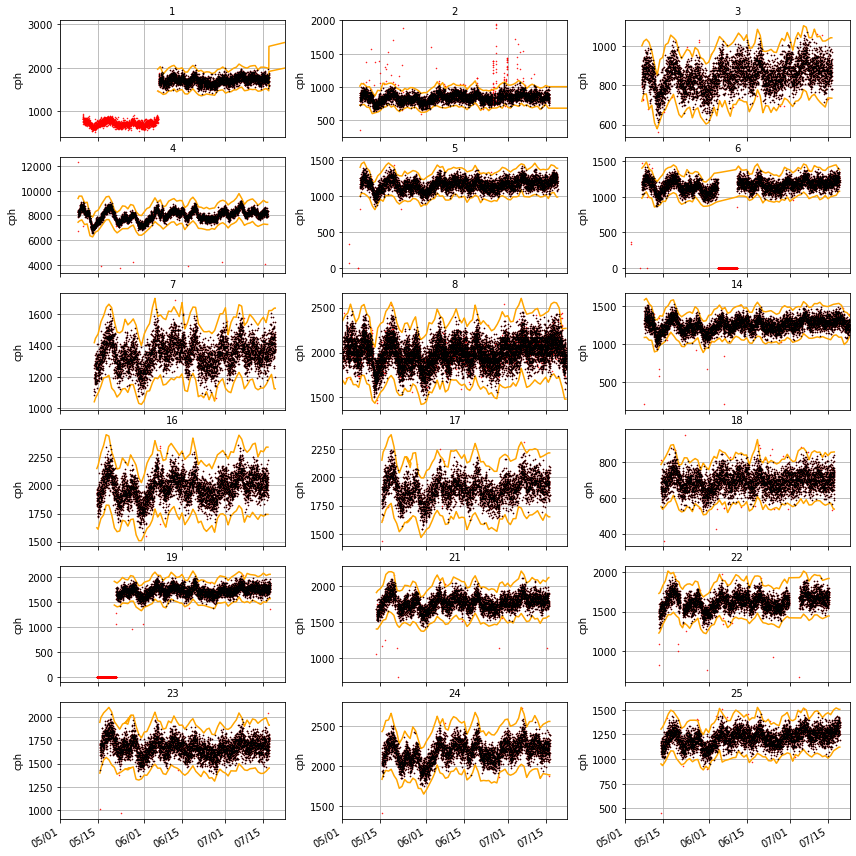

In [93]:
plt.rc('font', **{'size'   : 10})
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(12,12), sharex=True)
ax = ax.ravel()

xlim = dt.datetime(2019,5,1), dt.datetime(2019,7,23)#max_dtime

for i, key in enumerate(crns.keys()):
    ax[i].plot(crns[key].index, crns[key].cph1, linestyle="None", marker=".", ms=1, color="red")
    ax[i].plot(crns[key].index, crns[key].cph1_maxfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_minfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_filtered, linestyle="None", marker=".", ms=1, color="black")
    ax[i].set_title(key, fontsize=10)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    if key==2:
        ax[i].set_ylim(250,2000)
    #ax[i].set_ylim(pars[key]["mincph"], pars[key]["maxcph"]+200)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[i].grid()
    #ax[i].legend()    

fig.autofmt_xdate()    
plt.tight_layout(h_pad=0.1)

plt.savefig("crns_raw.png", dpi=150, bbox_inches="tight")

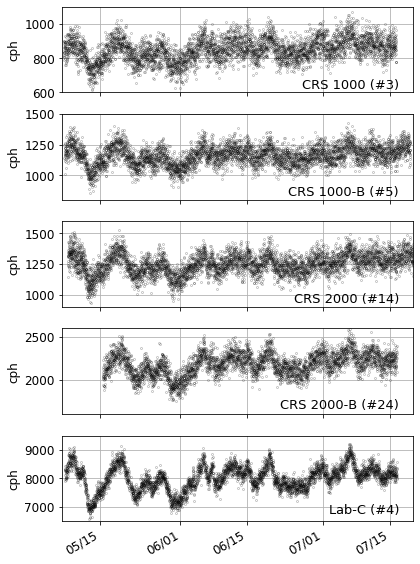

In [94]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=5, figsize=(6,8), sharex=True)
ax = ax.ravel()

xlim = dt.datetime(2019,5,7), dt.datetime(2019,7,20)#max_dtime

ylims = {3:[600, 1100], 5:[800, 1500], 14:[900,1600], 24:[1600, 2600],4:[6500,9500], }

for i, key in enumerate(ylims.keys()):
    plt.sca(ax[i])
    plt.plot(crns[key].index, crns[key].cph1_filtered, linestyle="None", marker="o", ms=2, 
               mec="black", mew=0.2, mfc="None", color="black")
    #plt.title(key, fontsize=10)
    plt.text(dt.datetime(2019,7,17), ylims[key][0]*1.04, "%s (#%d)" % (attrs.loc[key,"type"],key), 
             fontsize=13, horizontalalignment="right")
    
    plt.xlabel("")
    plt.ylabel("cph")
    plt.xlim(xlim)
    plt.ylim(ylims[key])
    #ax[i].set_ylim(pars[key]["mincph"], pars[key]["maxcph"]+200)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.grid()
    #ax[i].legend()    

fig.autofmt_xdate()    
plt.tight_layout()

plt.savefig("datapaper/crns_raw.png", dpi=150, bbox_inches="tight")

### Calibrate sensitivity

In [95]:
calfacts = {"CRS 1000": np.array([]), "CRS 1000-B": np.array([]), "CRS 2000": np.array([]),
            "CRS 2000-B": np.array([]), "Lab-C": np.array([]), "Styx Neutronica": np.array([])}
attrs["calfact"] = np.nan
for id in attrs[attrs.hascal & attrs.hasdata].id:
    #if (calperiods[id] is not None) and (id in ids): 
    probeavg = np.nanmean(crns[id][str(attrs.loc[id,"calstart"]):str(attrs.loc[id,"calend"])].cph1)
    ratio = float(probeavg / calavgcph[calavgcph.id==id].cph1)
    attrs.loc[id,"calfact"] = ratio
    calfacts[attrs.loc[id, "type"]] = np.append(calfacts[attrs.loc[id, "type"]], round(ratio,2))
for key in calfacts.keys():
    print("%s: %s, mean factor: %.2f" % (key, calfacts[key], np.mean(calfacts[key])) )
for id in attrs[~attrs.hascal & attrs.hasdata].id:
    attrs.loc[id,"calfact"] = np.mean(calfacts[attrs.loc[id,"type"]])

CRS 1000: [0.41], mean factor: 0.41
CRS 1000-B: [0.67 0.67], mean factor: 0.67
CRS 2000: [0.87], mean factor: 0.87
CRS 2000-B: [1.16 1.15 1.12 1.17 1.13 1.14], mean factor: 1.14
Lab-C: [4.55], mean factor: 4.55
Styx Neutronica: [], mean factor: nan


/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Extra steps for CRNS #3 and #2

For `#3`, not calibrator data is available. Instead, we had the chance to run `#3` right beside `#4` in Marquardt. That way, we can use the ratio between the two probes' neutron intensities, together with the calibration factor available for `#4`.

In [96]:
# CRNS 4
marq4 = pd.read_csv("/home/maik/b2drop/cosmicsense/inbox/marquardt/timeseries/crns/remote/4/4_CRNS.txt", sep="\t")
marq4.datetime = pd.to_datetime(marq4.datetime)
marq4 = marq4.set_index("datetime")
marq4["cph1"] = (marq4.counts1 + marq4.counts2) / cs.conv.s_to_h(marq4.nsecs1)

In [97]:
# CRNS 3
marq3 = pd.read_csv("/media/x/cosmicsense/data/marquardt/crns3_for_calibration_with_crns4/1908261215.003", sep=",", comment="#")
marq3.columns = ["rec_id", "datetime", "press1", "temp1", "relhum1", "volt", "counts1", "nsecs1", "counts2", "nsecs2"]
marq3.datetime = pd.to_datetime(marq3.datetime)
marq3 = marq3.set_index("datetime")
marq3["cph1"] = marq3.counts1 / cs.conv.s_to_h(marq3.nsecs1)

In [98]:
attrs.loc[3, "calfact"] = attrs.loc[4, "calfact"] * marq3["2019-08-26 13:00:00":"2019-08-30 09:00:00"].cph1.mean() / marq4["2019-08-26 13:00:00":"2019-08-30 09:00:00"].cph1.mean()
# Update calfact for #2 with new mean
calfacts["CRS 1000"] = np.append(calfacts["CRS 1000"], attrs.loc[3, "calfact"])
attrs.loc[2, "calfact"] = calfacts["CRS 1000"].mean()

In [99]:
attrs[["id", "calstart", "calend", "calfact"]]

,id,calstart,calend,calfact
id,,,,
1,1,1900-01-01 00:00:00,1900-01-01 00:00:00,1.145000
2,2,1900-01-01 00:00:00,1900-01-01 00:00:00,0.434515
3,3,1900-01-01 00:00:00,1900-01-01 00:00:00,0.459029
4,4,2019-05-28 09:45:00,2019-05-29 09:25:00,4.554603
5,5,2019-05-29 12:20:00,2019-05-31 08:35:00,0.669769
6,6,1900-01-01 00:00:00,1900-01-01 00:00:00,0.670000
7,7,1900-01-01 00:00:00,1900-01-01 00:00:00,0.670000
8,8,2019-06-04 16:00:00,2019-06-05 11:53:00,1.160192
9,9,2019-07-09 10:33:00,2019-07-10 13:08:00,NaN


#### Extra steps for #6 and #7

\begin{equation*}
\frac{sens_6}{calibrator} = \frac{sens_8}{calibrator} * \frac{sens_6}{sens_{est2000B}} * \frac{sens_{est2000B}}{sens_{8}}
\end{equation*}

\begin{equation*}
\frac{sens_7}{calibrator} = \frac{sens_8}{calibrator} * \frac{sens_7}{sens_{gwg2000B}} * \frac{sens_{gwg2000B}}{sens_{8}}
\end{equation*}

with $sens_{est2000B}$ and $sens_{gwg2000B}$ being two unnamed CRNS 2000-B that had been located close to $sens_6$ and $sens_7$ in 2018 in Esterberg and Graswang respectively, and close to $sens_8$ in 2018 (in Fendt?). 

In [100]:
def read_kit(f):
    kitdir = "/media/x/cosmicsense/data/fendt/crns/crossCalibrationDataFendt6and7/"
    df = pd.read_csv(kitdir+f, sep=",")
    df["Date Time(UTC)"] = pd.to_datetime(df["Date Time(UTC)"])
    df = df.set_index(["Date Time(UTC)"])
    df["cph1"] = df.N1Cts / cs.conv.s_to_h(df.N1ET_sec)
    return df
    
REF_est_2017 = read_kit("2017_crsREFest.dat")
REF_est_2017 = REF_est_2017[np.array(REF_est_2017.cph1<2400) & np.array(REF_est_2017.cph1>1400)]
REF_fen8_2017 = read_kit("2017_crsREFfen8.dat")
REF_gwg_2017 = read_kit("2017_crsREFgwg.dat")
REF_gwg_2017 = REF_gwg_2017[np.array(REF_gwg_2017.cph1<2400) & np.array(REF_gwg_2017.cph1>1400)]
EST_fen6_2018 = read_kit("2018_crsEST_fen6.dat")
EST_fen6_2018["cph3"] = EST_fen6_2018.N3Cts / cs.conv.s_to_h(EST_fen6_2018.N3ET_sec)
GWG_fen7_2018 = read_kit("2018_crsGWG_fen7.dat")
GWG_fen7_2018["cph3"] = GWG_fen7_2018.N3Cts / cs.conv.s_to_h(GWG_fen7_2018.N3ET_sec)

In [101]:
t1 = "2018-11-13"
t2 = "2018-11-16"
sensest_sens8 =  REF_est_2017.cph1.mean() / REF_fen8_2017.cph1.mean()
sensgwg_sens8 =  REF_gwg_2017.cph1.mean() / REF_fen8_2017.cph1.mean()
sens6_sensest = EST_fen6_2018[t1:t2].cph3.mean() / EST_fen6_2018[t1:t2].cph1.mean()
sens7_sensgwg = GWG_fen7_2018[t1:t2].cph3.mean() / GWG_fen7_2018[t1:t2].cph1.mean()
sens8_calibrator = attrs.loc[8, "calfact"]
sens6_calibrator = sens8_calibrator * sens6_sensest * sensest_sens8
sens7_calibrator = sens8_calibrator * sens7_sensgwg * sensgwg_sens8
#sens7_calibrator = 1.14 * sens7_sensgwg * sensgwg_sens8
print(round(sensest_sens8,3), round(sensgwg_sens8,3))
print(round(sens6_calibrator,3), round(sens7_calibrator, 3))
print(round(attrs.loc[5, "calfact"],3))

0.986 0.987
0.653 0.647
0.67


In [102]:
#attrs.loc[6, "calfact"] = sens6_calibrator
#attrs.loc[7, "calfact"] = sens7_calibrator

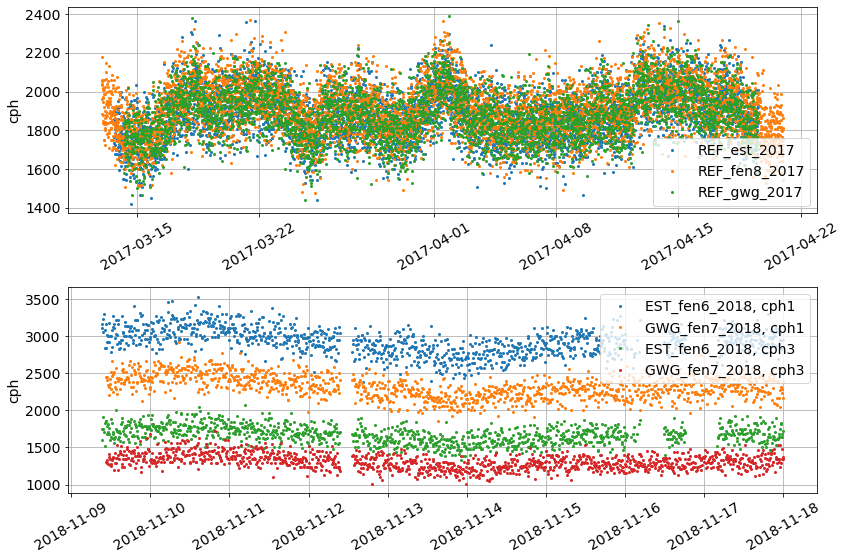

In [103]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(nrows=2, figsize=(12,8))
ax = ax.ravel()
plt.sca(ax[0])
plt.plot(REF_est_2017.cph1, lw=0, marker="o", ms=2, label="REF_est_2017")
plt.plot(REF_fen8_2017.cph1, lw=0, marker="o", ms=2, label="REF_fen8_2017")
plt.plot(REF_gwg_2017.cph1, lw=0, marker="o", ms=2, label="REF_gwg_2017")
plt.legend()
#plt.ylim(1250,2750)
plt.grid()
plt.ylabel("cph")
plt.xticks(rotation='30')


plt.sca(ax[1])
plt.plot(EST_fen6_2018.cph1, lw=0, marker="o", ms=2, label="EST_fen6_2018, cph1")
plt.plot(GWG_fen7_2018.cph1, lw=0, marker="o", ms=2, label="GWG_fen7_2018, cph1")
plt.plot(EST_fen6_2018.cph3, lw=0, marker="o", ms=2, label="EST_fen6_2018, cph3")
plt.plot(GWG_fen7_2018.cph3, lw=0, marker="o", ms=2, label="GWG_fen7_2018, cph3")
plt.ylabel("cph")
plt.legend()
plt.grid()
plt.xticks(rotation='30')

plt.tight_layout()

plt.savefig("crosscalib678.png", dpi=150, bbox_inches="tight")

#### Finally applying the sensitivity correction factors

In [104]:
for id in crns.keys():
    crns[id]["cph1cal"] = crns[id]["cph1_filtered"] / attrs.loc[id, "calfact"]

## Resample to uniform 20 minute interval

CRNS `#8` has a specific irrgularity: the sampling interval appears to be set to 10 minutes, but with frequent of length `1` inbetween. In order to fill these gaps, we decided to allow `nearest` to fill over `limit=2` while for the other CRNS, we only allow filling over `limit=1`.

In [105]:
dtrange = pd.date_range('2019-05-01 00:00:00', max_dtime, freq="20T")
crns20 = pd.DataFrame({}, index=dtrange)

for i, key in enumerate(crns.keys()):
    limit = 1
    if key==8:
        limit = 2
    crns20[key] = crns[key].cph1cal.resample('20T').nearest(limit=limit).reindex(dtrange)

## Correcting for variations in incoming neutron flux

#### NMBD station data

`nmdb.txt` contains reference (background) neutron count rates from [NMDB](http://www.nmdb.eu/nest/), for stations `KIEL2`, `JUNG`, `JUNG1`, and `DRBS` (Dourbes, Belgium). 

In [106]:
# NMDB data
nmdb = pd.read_csv("/media/x/cosmicsense/data/fendt/nmdb/nmdb.txt", sep=";", comment="#", na_values="   null")
nmdb.datetime = pd.to_datetime(nmdb.datetime)
nmdb = nmdb.set_index("datetime")

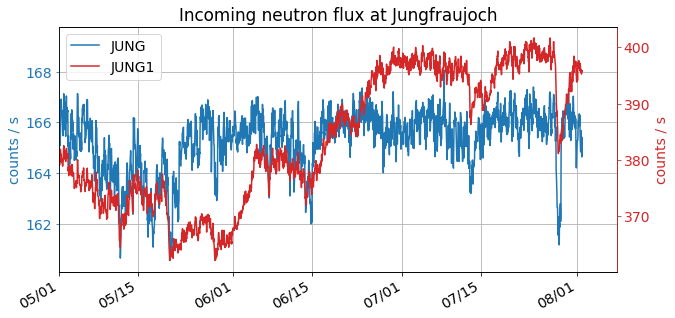

In [107]:
fig, ax1 = plt.subplots(figsize=(10, 5))
jungcol = "tab:blue"
jung = plt.plot(nmdb.index, nmdb.JUNG, color=jungcol)
plt.ylabel("counts / s", color=jungcol)
ax1.spines['left'].set_color(jungcol)
ax1.tick_params(axis='y', colors=jungcol)
ax1.grid()

ax2 = ax1.twinx()
jung1col = "tab:red"
jung1 = plt.plot(nmdb.index, nmdb.JUNG1, color="tab:red")
plt.ylabel("counts / s", color=jung1col)
ax2.spines['right'].set_color(jung1col)
ax2.tick_params(axis='y', colors=jung1col)

leg = plt.legend(jung+jung1, ["JUNG", "JUNG1"])
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.title("Incoming neutron flux at Jungfraujoch")

fig.autofmt_xdate() 

Several literature references (e.g. Zreda et al. 2012, Schroen et al. 2015, Andreasen et al. 2017) suggest to correct for variations in incoming neutron fluxes based on cosmic-ray neutron monitors available through http://www.nmdb.eu/nest. The idea is to compute a simple scaling factor $f_i$ based on measure neutron intensity $f_m$ and an arbitrary reference intensity $f_{ref}$ that depends on the actual neutron monitor.

\begin{equation*}
f_i = \frac{I_m}{I_{ref}}
\end{equation*}

In the dissertation thesis of Schroen (2016), a reference value $f_{ref}$ of 150 cps is suggested for the monitor on Jungfraujoch (JUNG).

In [108]:
fi = (nmdb.JUNG / nmdb.JUNG.mean())
fi.name="fi"
fi = fi.resample("1H").mean().resample("20T").ffill().reindex(dtrange)
fi2 = (nmdb.JUNG1 / nmdb.JUNG1.mean())
fi2.name="fi2"
fi2 = fi2.resample("1H").mean().resample("20T").ffill().reindex(dtrange)

## Correcting for variations in barometric pressure

Again based on Zreda et al. (2012), Andreasen et al. (2017) and many others, a correction factor $f_p$ is suggested in order to account for variations in barometric pressure.

\begin{equation*}
f_p = exp\Bigl(\frac{p_0 - p}{L}\Bigl)
\end{equation*}

Quoting from [Andreasen et al. (2017)](https://dl.sciencesocieties.org/publications/vzj/pdfs/16/8/vzj2017.04.0086):

> [...] $L$  is  the  mass  attenuation  length  for  high-energy  neutrons and is a function of cutoff rigidity
> (Desilets et al., 2006), $p$ is the barometric pressure at the time of measurement, and $P_0$ is an arbitrary
> reference pressure. Note that the units of $L$, $p$, and $p_0$ can be shielding depth (g/cm2) or pressure (Pa), 
> where $1 g/cm2 = 98.0665 Pa$. If shielding depth is used, $L$ ranges from 130 g/cm2 at high latitudes to 
> 144 g/cm2 at the equator (see Fig. 1).

[Zreda et al. (2012)](https://www.hydrol-earth-syst-sci.net/16/4079/2012/hess-16-4079-2012.pdf) complement that

> [... $p_0$] can be selected to be the long-term average pressure at the specific site, sea-level pressure, 
> or long-term averagepressure at a different reference site.

For $p_0$, we use $p_0 = 1013.25 mbar = 101325 Pa = 1033.23 g/cm²$ or the site average pressure, and $L=131.6$ for Germany (Fig. 1 in Andreasen et al. (2017).

In [109]:
p_0 = press.p0.mean()
L = 131.6 # g/cm2
fp = cs.core.corrfact_baro(press.p0, p_0, L)
fp = fp.resample("20T").ffill().reindex(dtrange)
fp.name="fp"

In [110]:
fp2 = cs.core.corrfact_baro(meteo.press2m, meteo.press2m.mean(), L)
fp2 = fp2.resample("20T").ffill().reindex(dtrange)
fp2.name="fp2"

## Correcting for variations in atmospheric water vapor

In their overview, Andreasen et al. (2017) refer to Rosolem et al. (2013) when accounting for the effects of atmospheric water vapor:

\begin{equation*}
f_{wv} = 1 + 0.0054 * (h - h_{ref})
\end{equation*}

where $h$ is the absolute humidity of the air (in g/m3), and $h_{ref}$ is the absolute humidity at an arbitrary reference time.

The references do not elaborate on how to obtain the absolute humidity, but given the relative humidity and air temperature, we typically obtain $h$ by combining 

1. Relationship between vapor pressure $e$, saturated vapor pressure $e_s$ and relative humidity $rh$ (in %)

\begin{equation*}
e = e_s * rh / 100.
\end{equation*}

2. August-Roche-Magnus approximation of relation betweeen $e_s$ (mbar) and air temperature $T$ (in deg C) 

\begin{equation*}
e_s(T) = 6.1094 * exp\Bigl(\frac{17.625*T}{T + 243.04}\Bigl)
\end{equation*}

3. Universal law of perfect gases (with volume $V$, mass $m$, specific gas constant $R_S=461.4 J/kg/K$ for water vapor)

\begin{equation*}
e * V = m * R_s * T
\end{equation*}

In [111]:
fwv2 = cs.core.corrfact_vapor_rosolem(meteo.abshum2m)
fwv2.name = "fwv2"
fwv2 = fwv2.resample("20T").ffill().reindex(dtrange)
fwv = cs.core.corrfact_vapor_rosolem(temphum.abshum2m)
fwv.name = "fwv"
fwv = fwv.resample("20T").ffill().reindex(dtrange)

## Combining the correction factors

We can now inspect the different correction factor, and use them to correct our neutron counts. According to Andreasen, this is done via

\begin{equation*}
N_{cor} = \frac{N*f_{wv}}{f_p*f_i}
\end{equation*}

In [112]:
factorcombined = fwv2 / (fi * fp2)

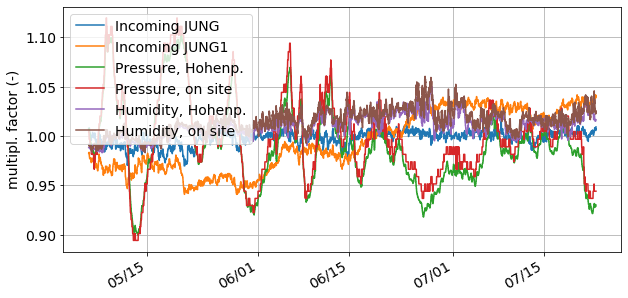

In [113]:
plt.rc('font', **{'size'   : 14})
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.plot(fi["2019-05-06":].index, fi["2019-05-06":], label="Incoming JUNG")
plt.plot(fi2["2019-05-06":].index, fi2["2019-05-06":], label="Incoming JUNG1")
plt.plot(fp["2019-05-06":].index, fp["2019-05-06":], label="Pressure, Hohenp.")
plt.plot(fp2["2019-05-06":].index, fp2["2019-05-06":], label="Pressure, on site")
plt.plot(fwv["2019-05-06":].index, fwv["2019-05-06":], label="Humidity, Hohenp.")
plt.plot(fwv2["2019-05-06":].index, fwv2["2019-05-06":], label="Humidity, on site")
plt.ylabel("multipl. factor (-)")
#prec["2019-05-06":].depth.cumsum().plot()
plt.grid() 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#plt.title("Correction factors")
plt.legend()#loc="lower left")
fig.autofmt_xdate() 

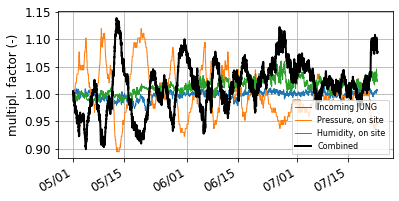

In [114]:
plt.rc('font', **{'size'   : 12})
fig = plt.figure(figsize=(6, 3))
plstart = "2019-05-01"
plend = "2019-07-22"
ax = plt.subplot(111)
plt.plot(fi[plstart:plend].index, fi[plstart:plend], lw=1, label="Incoming JUNG")
plt.plot(fp2[plstart:plend].index, fp2[plstart:plend], lw=1, label="Pressure, on site")
plt.plot(fwv2[plstart:plend].index, fwv2[plstart:plend],  lw=1, label="Humidity, on site")
plt.plot(factorcombined[plstart:plend].index, factorcombined[plstart:plend], lw=2, label="Combined", color="black")
plt.ylabel("multipl. factor (-)")
#prec["2019-05-06":].depth.cumsum().plot()
plt.grid() 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#plt.title("Correction factors")
plt.legend(loc="lower right", fontsize=8)
fig.autofmt_xdate()
plt.savefig("corrfactors.png", dpi=300, bbox_inches="tight")

In [115]:
crns20c = crns20.copy()
for id in crns20c.keys():
    #crns20c[id] = crns20c[id] * fwv / (fi * fp)
    crns20c[id] = crns20c[id] * factorcombined

### Weighted spatial average of neutron intensity at 20 minute interval

In [116]:
# Each CRNS provides a weight on a common grid, based on distance and footprint characteristics
allw = np.zeros((np.sum(attrs.hasdata), len(xxyy)))
for i, id in enumerate(attrs.index[attrs.hasdata]):
    dist = cs.util.distance(np.array([attrs.loc[id,"x"], attrs.loc[id,"y"]]).T, xxyy)
    w = cs.core.horizontal_weight_koehli_approx(dist)# / (2 * np.pi * dist)
    #w = cs.core.horizontal_weight_zreda2008b(dist)
    w[dist>300] = 0
    allw[i] = w#normfunc(w)

In [117]:
arealcph = np.zeros((len(crns20c),len(xxyy)))
for i in range(len(arealcph)):
    tmp = np.array(crns20c.iloc[i]).reshape((-1,1))
    goodix = ~np.isnan(tmp).ravel()
    arealcph[i] = np.sum(tmp[goodix] * allw[goodix], axis=0) / allw[goodix].sum(axis=0)

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [118]:
crns20c["arealavg"] = np.nanmean(arealcph, axis=1)

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [119]:
arealavg24h_mean = crns20c["arealavg"].rolling("24H", min_periods=3*24-5).mean()
arealavg24h_std = crns20c["arealavg"].rolling("24H", min_periods=3*24-5).std()
arealavg24h_cov = 100 * arealavg24h_std / arealavg24h_mean

In [120]:
ids = np.array(attrs[attrs.hasdata].id)
singlecrns24h_mean = crns20c[ids].rolling("24H", min_periods=3*24-5).mean()
singlecrns24h_std = crns20c[ids].rolling("24H", min_periods=3*24-5).std()
singlecrns24h_cov = 100 * singlecrns24h_std / singlecrns24h_mean
singlecrns24h_cov_mean = singlecrns24h_cov.mean(axis=1)

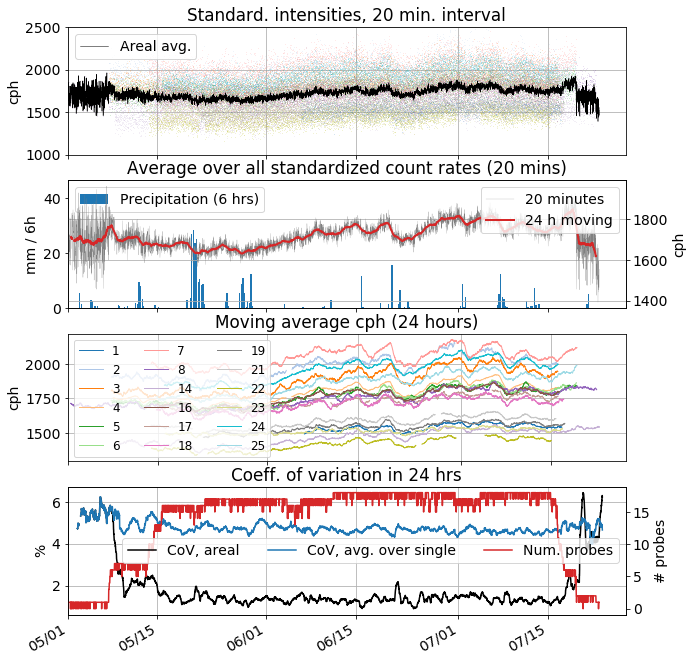

In [121]:
plt.rc('font', **{'size'   : 14})

colors = plt.cm.tab20(np.linspace(0,1,len(ids)))

fig, ax = plt.subplots(nrows=4, figsize=(10,12))

plt.sca(ax[0])
for i, id in enumerate(ids):
    plt.plot(crns20c.index, crns20c[id], color=colors[i], lw=0, marker=".", ms=1, mec="None")
#mpl = plt.plot(crns20c.index, crns20c[ids].mean(axis=1), color="black", label="Mean over all probes", lw=0.8)
mpl = plt.plot(crns20c.index, crns20c["arealavg"], color="black", label="Areal avg.", lw=0.5)
plt.grid()
plt.title("Standard. intensities, 20 min. interval")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.legend(mpl, ["Areal avg."])
plt.ylabel("cph")
plt.ylim(1000, 2500)

plt.sca(ax[1])
tmp = prec.depth.resample("6H", loffset=dt.timedelta(hours=3)).sum()
plt.bar(tmp.index, tmp, linewidth=0, width=0.2,  label="Precipitation (6 hrs)")
plt.legend(loc="upper left")
#plt.grid()
plt.ylabel("mm / 6h")

ax2 = ax[1].twinx()
plt.plot(crns20c.index, crns20c["arealavg"], lw=0.2, color="grey", label="20 minutes")
plt.plot(crns20c.index-dt.timedelta(hours=12), arealavg24h_mean, lw=2, color="tab:red", label="24 h moving")
plt.xlim(ax[0].get_xlim())
#ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
#plt.ylim(7600, 8600)
plt.grid()
plt.legend(loc="upper right")
plt.title("Average over all standardized count rates (20 mins)")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.ylabel("cph")

plt.sca(ax[2])
crns24hchst = crns20c.resample("24H").mean()
for i, id in enumerate(ids):
    tmp = crns20c[id].rolling("24H", min_periods=3*24-10).mean()
    plt.plot(tmp.index-dt.timedelta(hours=12), tmp, lw=1, color=colors[i], label=(str(id)))
    #plt.plot(crns24hchst.index+dt.timedelta(hours=12), crns24hchst[id], color=colors[i])
#plt.ylim(7600, 8800)
plt.grid()
plt.title("Moving average cph (24 hours)")
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.legend(ncol=3, loc="upper left", fontsize=12)
plt.ylabel("cph")

plt.sca(ax[3])
tmp = crns20c[ids].mean(axis=1).rolling("24H").std()
tmp2 = crns20c[ids].count(axis=1)#.rolling("24H").mean()
plareal = plt.plot(crns20c.index + dt.timedelta(hours=12), arealavg24h_cov, color="black")
plsingle = plt.plot(crns20c.index + dt.timedelta(hours=12), singlecrns24h_cov_mean, color="tab:blue")
plt.xlim(ax[0].get_xlim())
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.grid()
plt.title("Coeff. of variation in 24 hrs")
plt.ylabel("%")
ax4 = ax[3].twinx()
plnum = plt.plot(tmp2.index, tmp2, color="tab:red", label="# probes")
plt.ylabel("# probes")
plt.legend(plareal+plsingle+plnum, ["CoV, areal", "CoV, avg. over single", "Num. probes"], ncol=3)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))


fig.autofmt_xdate() 
#plt.tight_layout()

## Organize soil moisture campaign data

In [122]:
cyls = pd.read_excel("/media/x/cosmicsense/data/fendt/theta_sheet_converted.xlsx", sheet_name="cylinder samples_lab results")
fdr = pd.read_excel("/media/x/cosmicsense/data/fendt/theta_sheet_converted.xlsx", sheet_name="FDR-readings_converted")

In [123]:
cyls.columns = ['location_id', 'depth_index', 'replicate', 'composite_id', 'depth', 
                'gross weight sample, fresh [g]', 'weight bag [g]', 'remarks', 
                'Number of sample (bags)', 'weight container', 'dry weight soil+container after 105°C',
                'freshweight', 'dry weight soil after 105°C', 'gravimetric water content (g/g soil (DW))',
                'theta', 'comment', 'bd', 'poro', 'wfps']

In [124]:
fdr = fdr.iloc[:-3]
fdr.columns = ['id', 'location_id', 'depth', 'fdr1',
       'fdr2', 'fdr3', 'time', 'device', 'remarks', 'epsilon1',
       'epsilon2', 'epsilon3', 'theta1', 'theta2', 'theta3', 'thetamean']
fdr.location_id = fdr.location_id.astype(int)

### Relate CRNS locations to ground truth sampling locations

In [125]:
# Find the closest CRNS location for each sampling location
crnsxy = np.array([attrs.x, attrs.y]).T
tree = spatial.KDTree(crnsxy)
nextdist, nextix = tree.query(np.array([locs.x, locs.y]).T, k=1)
locs["crnsid"] = attrs.index[nextix]

In [126]:
# Assign a cylinder location ID to each CRNS in attribute table
attrs["cylid"] = -9999
for locid in np.unique(cyls["location_id"]):
    attrs.loc[locs.loc[locid, "crnsid"], "cylid"] = locid
# Assign cylinder stats to each CRNS in attribute table
attrs["rhob"] = np.nan
attrs["theta"] = np.nan

### Reorganise profile data

In [127]:
thetaprofs = {}
bdprofs = {}
locs["type"] = ""
for locid in locs.index:
    if np.in1d(locid, cyls.location_id)[0]:
        # cylinder profile
        locs.loc[locid, "type"] = "cyl"
        sortix = np.array(np.argsort(cyls.loc[cyls.location_id==locid, "depth"]))
        deptharr = np.unique(np.array(cyls.loc[cyls.location_id==locid, "depth"])[sortix]).reshape((-1,1))
        bdarr = np.array(cyls.loc[cyls.location_id==locid, "bd"])[sortix].reshape((-1,2))
        thetaarr = np.array(cyls.loc[cyls.location_id==locid, "theta"])[sortix].reshape((-1,2))
        bdprofs[locid] = np.hstack((deptharr, bdarr, bdarr.mean(axis=1).reshape((-1,1))))
        thetaprofs[locid] = np.hstack((deptharr, thetaarr, thetaarr.mean(axis=1).reshape((-1,1))))
    elif np.in1d(locid, fdr.location_id)[0]:
        # ATTENTION: we discard the FDR profile at a cylinder location!
        # FDR profile
        locs.loc[locid, "type"] = "fdr"
        sortix = np.array(np.argsort(fdr.loc[fdr.location_id==locid, "depth"]))
        thetaarr = np.array(fdr.loc[fdr.location_id==locid, ["depth", "theta1", "theta2", "theta3", "thetamean"]])[sortix]
        if not np.all(np.isnan(thetaarr[:,4])):
            thetaprofs[locid] = thetaarr
        else:
            locs.loc[locid, "type"] = "invalid"
    else:
        # No match
        locs.loc[locid, "type"] = "unknown"
        print("WARNING: location %d is neither FDR nor cylinder profile." % locid)   

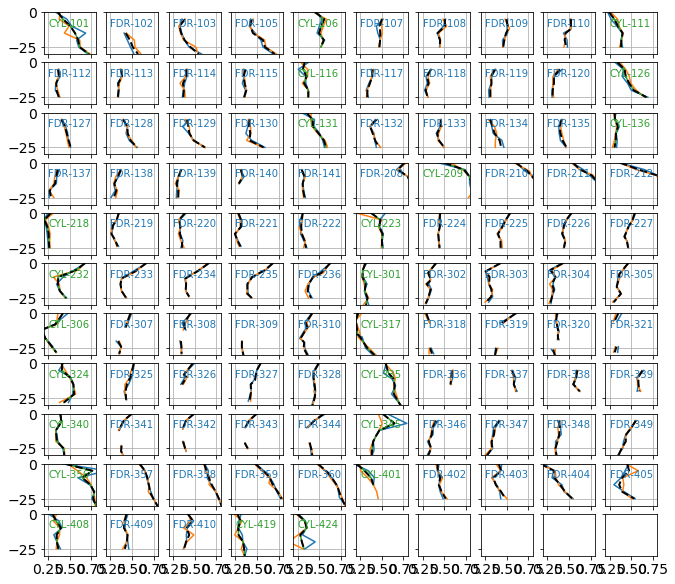

In [128]:
fig, ax = plt.subplots(nrows=11, ncols=10, figsize=(11,10), sharex=True, sharey=True)
ax = ax.ravel()
for i, key in enumerate(thetaprofs.keys()):
    try:
        depth = thetaprofs[key][:,0]
        if thetaprofs[key].shape[1] == 4:
            ax[i].plot(thetaprofs[key][:,1:4], -depth)
        else:
            ax[i].plot(thetaprofs[key][:,1:3], -depth)
        ax[i].plot(thetaprofs[key][:,-1], -depth, color="black", lw=2, ls="dashed")
        ax[i].set_ylim(-30,0)
        ax[i].set_xlim(0.2,0.8)
        ax[i].grid()
    except ValueError:
        print(key)

    if locs.loc[key, "type"] == "cyl":
        txtcol = "tab:green"
        txt = "CYL-%d" % key
    elif locs.loc[key, "type"] == "fdr":
        txtcol = "tab:blue"
        txt = "FDR-%d" % key
    else:
        txtcol = "tab:red"
        txt = "MISSING"
    if np.all(np.isnan(thetaprofs[key][:,-1])):
        txtcol = "tab:red"
       
    ax[i].text(0.25, -10, txt, fontsize=10, color=txtcol)

### Retrieve mean profiles and fit standard shape functions to profiles

In [129]:
def proffun1(depth, upper, lower, thresh):
    """Standard bulk density profile shape in Fendt    
    """
    y = upper + ((lower - upper)/thresh) * depth
    minbd = min(upper, lower)
    maxbd = max(upper, lower)
    y[y > maxbd] = maxbd
    y[y < minbd] = minbd
    return(y)    

In [130]:
def proffun2(depth, upper, lower):
    """Standard theta profile shape in Fendt    
    """
    y = upper + ((lower - upper)/30.) * depth
    return(y) 

In [131]:
def objfun(pars, proffun, obsprof, depths):
    fitprof = proffun(depths, *pars)
    return( np.sum((obsprof - fitprof)**2) )

In [132]:
locs["theta0"] = np.nan
locs["theta30"] = np.nan
for i, locid in enumerate(thetaprofs.keys()):
    ix = ~np.isnan(thetaprofs[locid][:,-1])
    optres = minimize(fun=objfun, x0=np.array([0.4, 0.5]), args=(proffun2, thetaprofs[locid][ix,-1], thetaprofs[locid][ix,0]))["x"]    
    locs.loc[locid, "theta0"] = optres[0]
    locs.loc[locid, "theta30"] = optres[1]

In [133]:
locs["bd0"] = np.nan
locs["bd30"] = np.nan
for i, locid in enumerate(bdprofs.keys()):
    ix = ~np.isnan(bdprofs[locid][:,-1])
    optres = minimize(fun=objfun, x0=np.array([1.0, 1.0]), args=(proffun2, bdprofs[locid][ix,-1], bdprofs[locid][ix,0]))["x"]    
    locs.loc[locid, "bd0"] = optres[0]
    locs.loc[locid, "bd30"] = optres[1]

In [134]:
locs.loc[102, ["theta0", "theta30"]].tolist()

[0.3632702573895403, 0.545191051828074]

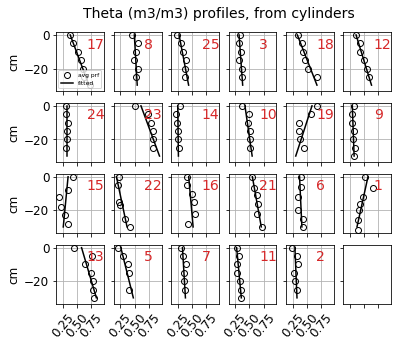

In [135]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(6,5), sharex=True, sharey=True)
ax = ax.ravel()
plotdepths = np.arange(0,30,0.1)
for i, locid in enumerate(locs.index[locs.type=="cyl"]):
    plt.sca(ax[i])
    ax[i].plot(thetaprofs[locid][:,-1], -thetaprofs[locid][:,0], lw=0, marker="o", mfc="None", color="black", label="avg prf")
    #ax[i].plot(np.nanmean(cyltheta[id], axis=1), -obsdepths, lw=1, color="red", label="observed")
    ax[i].plot(proffun2(plotdepths, *locs.loc[locid, ["theta0", "theta30"]].tolist()), -plotdepths, color="black", label="fitted")
    #ax[i].set_title(str(id))
    label = "%d" % attrs.id[attrs.cylid==locid]
    ax[i].text(.67,-8, label, fontsize=14, color="tab:red")
    ax[i].grid()
    if i in [0, 6, 12, 18]:
        ax[i].set_ylabel("cm")
    if i==0:
        ax[i].legend(loc="lower right", fontsize=6)
    plt.xticks(rotation=50)
title = fig.suptitle("Theta (m3/m3) profiles, from cylinders", y=0.95, fontsize=14)
ax[-1].tick_params(labelbottom=False)
#fig.autofmt_xdate()

plt.savefig("cyl_theta.png", dpi=150, bbox_inches="tight")

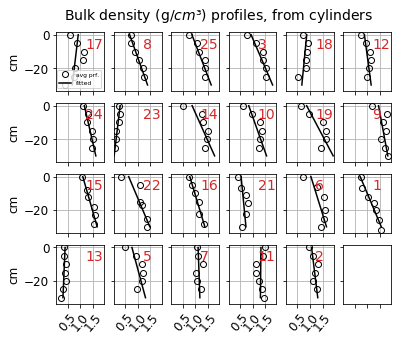

In [136]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(6,5), sharex=True, sharey=True)
ax = ax.ravel()
plotdepths = np.arange(0,30,0.1)
for i, locid in enumerate(locs.index[locs.type=="cyl"]):
    plt.sca(ax[i])
    ax[i].plot(bdprofs[locid][:,-1], -bdprofs[locid][:,0], lw=0, marker="o", mfc="None", color="black", label="avg prf.")
    #ax[i].plot(bd[id].mean(axis=1), -obsdepths, lw=1, color="red", label="observed")
    ax[i].plot(proffun2(plotdepths, *locs.loc[locid, ["bd0", "bd30"]].tolist()), -plotdepths, color="black", label="fitted")
    #ax[i].set_title(str(id))
    label = "%d" % attrs.id[attrs.cylid==locid]
    ax[i].text(1.2,-8, label, fontsize=14, color="tab:red")
    ax[i].grid()
    if i in [0, 6, 12, 18]:
        ax[i].set_ylabel("cm")
    if i==0:
        ax[i].legend(loc="lower right", fontsize=6)
    plt.xticks(rotation=50)
title = fig.suptitle("Bulk density (g/$cm³$) profiles, from cylinders", y=0.95, fontsize=14)
#fig.autofmt_xdate(rotation=50, bottom=0.1)
plt.xlim(0.05, 1.95)
ax[-1].tick_params(labelbottom=False)

plt.savefig("cyl_bd.png", dpi=150, bbox_inches="tight")

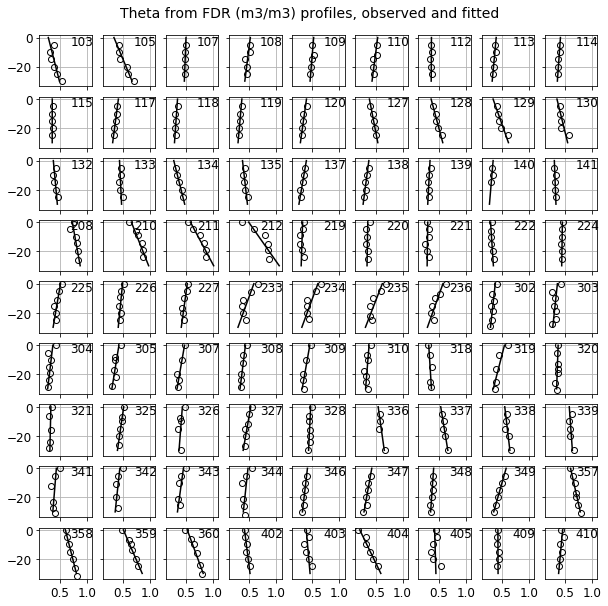

In [137]:
fig, ax = plt.subplots(nrows=9, ncols=9, figsize=(10,10), sharex=True, sharey=True)
ax = ax.ravel()
plotdepths = np.arange(0,30,0.1)
for i, locid in enumerate(locs.index[locs.type=="fdr"][1:]):
    ax[i].plot(thetaprofs[locid][:,-1], -thetaprofs[locid][:,0], lw=0, marker="o", mfc="None", color="black", label="avg. prof.")
    #ax[i].plot(np.nanmean(cyltheta[id], axis=1), -obsdepths, lw=1, color="red", label="observed")
    ax[i].plot(proffun2(plotdepths, *locs.loc[locid, ["theta0", "theta30"]].tolist()), -plotdepths, color="black", label="fitted")
    #ax[i].set_title(str(id))
    ax[i].text(.7,-5,str(locid), fontsize=12)
    ax[i].grid()
    #if i==0:
    #    ax[i].legend(loc="lower right", fontsize=8)
title = fig.suptitle("Theta from FDR (m3/m3) profiles, observed and fitted", y=0.92, fontsize=14)

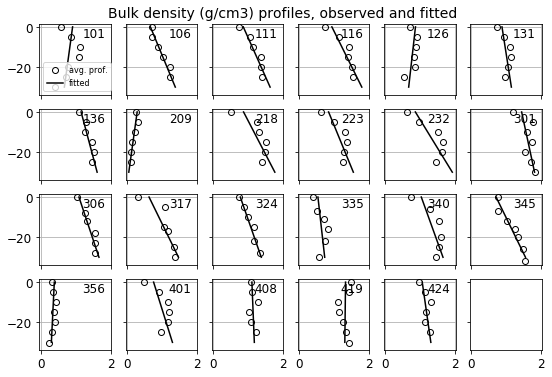

In [138]:
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(9,6), sharex=True, sharey=True)
ax = ax.ravel()
plotdepths = np.arange(0,30,0.1)
for i, locid in enumerate(locs.index[locs.type=="cyl"]):
    ax[i].plot(bdprofs[locid][:,-1], -bdprofs[locid][:,0], lw=0, marker="o", mfc="None", color="black", label="avg. prof.")
    #ax[i].plot(bd[id].mean(axis=1), -obsdepths, lw=1, color="red", label="observed")
    ax[i].plot(proffun2(plotdepths, *locs.loc[locid, ["bd0", "bd30"]].tolist()), -plotdepths, color="black", label="fitted")
    ax[i].text(1.2,-5,str(locid))
    ax[i].grid()
    if i==0:
        ax[i].legend(loc="lower left", fontsize=8)
title = fig.suptitle("Bulk density (g/cm3) profiles, observed and fitted", y=0.92, fontsize=14)

### Interpolation on a regular grid

In [139]:
# Organize input arrays for gridding
thetaix = ~np.isnan(locs.theta0)
bdix = ~np.isnan(locs.bd0) #np.array(locs[~np.isnan(locs.bd0)][["x", "y"]])
# Bulk density
bdxy = np.array(locs[bdix][["x", "y"]])
bdupper = np.array(locs[bdix].bd0)
bdlower = np.array(locs[bdix].bd30)
# Theta
thetaxy = np.array(locs[thetaix][["x", "y"]])
thetaupper = np.array(locs[thetaix].theta0)
thetalower = np.array(locs[thetaix].theta30)

In [140]:
# theta
#ok = wradlib.ipol.OrdinaryKriging(thetaxy, xxyy, cov='1.0 Exp(500.)', nnearest=10)
ok = wradlib.ipol.OrdinaryKriging(thetaxy, xxyy, cov='1.0 Exp(500)', nnearest=25)
#ok = wradlib.ipol.Idw(thetaxy, xxyy, nnearest=10, p=1.5)
ip_thetaupper = ok(thetaupper)
ip_thetalower = ok(thetalower)
# bd
ok = wradlib.ipol.OrdinaryKriging(bdxy, xxyy, cov='1.0 Exp(500.)', nnearest=10)
ip_bdupper = ok(bdupper)
ip_bdlower = ok(bdlower)

In [141]:
avgtheta_from_fit = proffun2(np.arange(0,30).reshape((-1,1)), ip_thetaupper, ip_thetalower).mean(axis=0)
avgbd_from_fit = proffun2(np.arange(0,30).reshape((-1,1)), ip_bdupper, ip_bdlower).mean(axis=0)

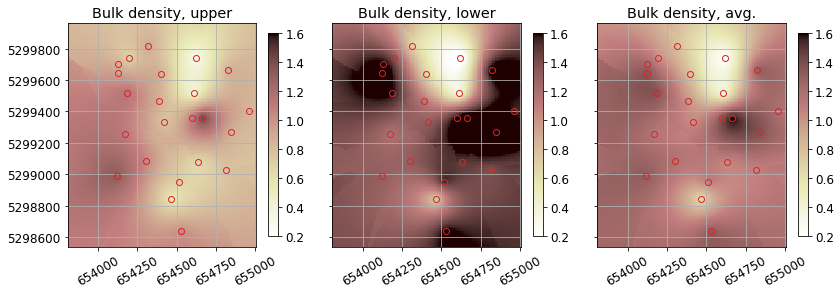

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6), sharex=True, sharey=True)
ax = ax.ravel()

vmin=0.2
vmax=1.6

cmap = plt.cm.pink_r

plt.sca(ax[0])
ax[0].set_aspect("equal")
p = plt.pcolormesh(xx, yy, ip_bdupper.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.5)
plt.plot(locs[~np.isnan(locs.bd0)].x, locs[~np.isnan(locs.bd0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
plt.title("Bulk density, upper")
plt.grid()
plt.xticks(rotation=30)

plt.sca(ax[1])
ax[1].set_aspect("equal")
p = plt.pcolormesh(xx, yy, ip_bdlower.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.5)
plt.plot(locs[~np.isnan(locs.bd0)].x, locs[~np.isnan(locs.bd0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
plt.title("Bulk density, lower")
plt.grid()
plt.xticks(rotation=30)

plt.sca(ax[2])
ax[2].set_aspect("equal")
p = plt.pcolormesh(xx, yy, avgbd_from_fit.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.5)
plt.plot(locs[~np.isnan(locs.bd0)].x, locs[~np.isnan(locs.bd0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
plt.grid()
plt.title("Bulk density, avg.")
plt.xticks(rotation=30)
plt.tight_layout()

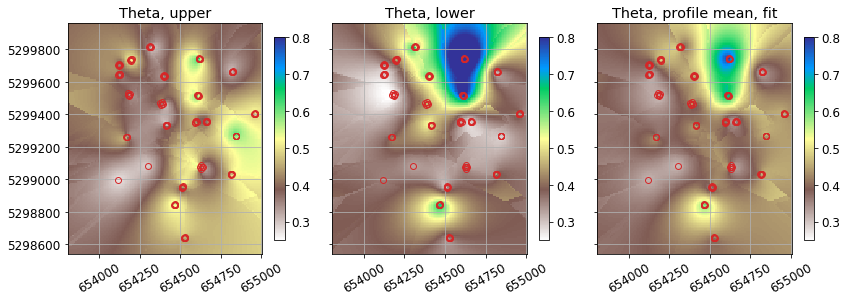

In [143]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6), sharex=True, sharey=True)
ax = ax.ravel()

vmin=0.25
vmax=0.8

cmap = plt.cm.terrain_r

plt.sca(ax[0])
ax[0].set_aspect("equal")
p = plt.pcolormesh(xx, yy, ip_thetaupper.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.5)
plt.plot(locs[~np.isnan(locs.theta0)].x, locs[~np.isnan(locs.theta0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
plt.title("Theta, upper")
plt.xticks(rotation=30)
plt.grid()

plt.sca(ax[1])
ax[1].set_aspect("equal")
p = plt.pcolormesh(xx, yy, ip_thetalower.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.5)
plt.plot(locs[~np.isnan(locs.theta0)].x, locs[~np.isnan(locs.theta0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
plt.title("Theta, lower")
plt.xticks(rotation=30)
plt.grid()

plt.sca(ax[2])
ax[2].set_aspect("equal")
p = plt.pcolormesh(xx, yy, avgtheta_from_fit.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p, shrink=0.5)
plt.plot(locs[~np.isnan(locs.theta0)].x, locs[~np.isnan(locs.theta0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
plt.grid()
plt.title("Theta, profile mean, fit")
plt.xticks(rotation=30)

plt.tight_layout()

### Compute bulk density and average soil moisture per CRNS probe

1. Initial guess theta and bulk density in CRNS footprint
2. Compute vertical weights for each grid cell in the cutoff radius
3. Compute vertical weighted average for each profile
4. Compute horizontal weights for each grid cell in the cuttoff radius
4. Compute horizontally weighted average
5. Iterate until theta and bulk density become converge (typically within 3 steps)

In [144]:
crnsxy = np.array([attrs.x, attrs.y]).T
tree = spatial.KDTree(xxyy)
ix = tree.query_ball_point(crnsxy, r=150)

#### Penetration depth and vertical weights

In [145]:
# Initial guess of theta in the footprint
attrs["thetaini"] = np.nan
attrs["bdini"] = np.nan
for i, id in enumerate(attrs.index):
    attrs.loc[id, "thetaini"] = avgtheta_from_fit[ix[i]].mean()
    attrs.loc[id, "bdini"] = avgbd_from_fit[ix[i]].mean()

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """


In [146]:
# Required input vars: pressure, abs. hum., vegetation height
press_oncamp = press.p0["2019-06-25 09:00:00":"2019-06-26 17:00:00"].mean()
h_oncamp = temphum["2019-06-25 09:00:00":"2019-06-26 17:00:00"].abshum2m.mean()
Hveg = 0.
depths = np.arange(0,30)

In [147]:
maxiter = 5
for i, id in enumerate(attrs.index):   
    if not attrs.loc[id, "hasdata"]:
        continue
    print("Iterating for CRNS #%d..." % id)
    # Initial guess
    thetaguess = attrs.loc[id, "thetaini"]
    bdguess = attrs.loc[id, "bdini"]
    for iteri in range(maxiter):
        print("\ttheta=%.3f, bd=%.2f" % (thetaguess, bdguess) )
        # 3-d grid of theta and bulk density in cutoff radius
        theta_vertgrd = proffun2(depths.reshape((-1,1)), ip_thetaupper[ix[i]], ip_thetalower[ix[i]])
        bd_vertgrd = proffun2(depths.reshape((-1,1)), ip_bdupper[ix[i]], ip_bdlower[ix[i]])
        # Distances of grid cells to probe
        dists = cs.util.distance(crnsxy[i], xxyy[ix[i]])
        # Vertical weights
        vweights = cs.core.vertical_weight_koehli(dists, depths, thetaguess, press_oncamp, Hveg, bdguess)
        theta_vertavgs = np.sum(vweights * theta_vertgrd, axis=0) / np.sum(vweights, axis=0)
        bd_vertavgs = np.sum(vweights * bd_vertgrd, axis=0) / np.sum(vweights, axis=0 )
        hweights = cs.core.horizontal_weight_koehli(dists, press_oncamp, Hveg, thetaguess, h_oncamp)
        thetaguess = np.sum(hweights * theta_vertavgs) / np.sum(hweights)
        bdguess = np.sum(hweights * bd_vertavgs) / np.sum(hweights)
        
    attrs.loc[id, "theta"] = thetaguess
    attrs.loc[id, "rhob"] = bdguess

Iterating for CRNS #1...
	theta=0.427, bd=1.02
	theta=0.440, bd=0.87
	theta=0.438, bd=0.89
	theta=0.439, bd=0.89
	theta=0.439, bd=0.89
Iterating for CRNS #2...
	theta=0.358, bd=1.16
	theta=0.344, bd=1.09
	theta=0.344, bd=1.10
	theta=0.344, bd=1.10
	theta=0.344, bd=1.10
Iterating for CRNS #3...
	theta=0.373, bd=1.25
	theta=0.390, bd=1.09
	theta=0.388, bd=1.10
	theta=0.388, bd=1.10
	theta=0.388, bd=1.10
Iterating for CRNS #4...
	theta=0.436, bd=1.06
	theta=0.430, bd=0.99
	theta=0.431, bd=1.00
	theta=0.431, bd=1.00
	theta=0.431, bd=1.00
Iterating for CRNS #5...
	theta=0.411, bd=1.09
	theta=0.393, bd=0.97
	theta=0.395, bd=0.98
	theta=0.394, bd=0.98
	theta=0.394, bd=0.98
Iterating for CRNS #6...
	theta=0.439, bd=1.20
	theta=0.452, bd=1.08
	theta=0.451, bd=1.09
	theta=0.451, bd=1.09
	theta=0.451, bd=1.09
Iterating for CRNS #7...
	theta=0.378, bd=1.19
	theta=0.385, bd=1.14
	theta=0.385, bd=1.15
	theta=0.385, bd=1.15
	theta=0.385, bd=1.15
Iterating for CRNS #8...
	theta=0.422, bd=1.06
	theta=0

### Calibrate N0 parameter

Volumetric soil moisture is estimated from a single relation that includes a local calibration parameter $N_0$. [Desilets et al. (2010)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2009WR008726) suggested the following one:

\begin{equation*}
\theta = \Bigl(\frac{a_0}{\frac{N_{corr}}{N_0} - a_1} - a_2\Bigl) * \frac{\rho_b}{\rho_w}
\end{equation*}

While $a_0$, $a_1$ and $a_2$ are empirical parameters, soil bulk density $\rho_b$ can be measured or retrieved via transfer functions or literature, the density of water $\rho_w$ is a function of temperature and salinity, although the approximate value of 1000 kg/m3 is can be used without introducing much error as compared to other uncertainties.

The parameter $N_0$ depends on the local hydrogen pool and footprint, and needs to be obtained from calibration with gravimetric soil moisture measurements in the footprint at a defined point in time. For the time being, we just take a wild guess and set $N_0$ to 1500 cph.

#### Consider the effect of vegetation

Attention: This approach is extremely quick and dirty, yet.

In case we want to estimate one uniform calibration parameter, we have to assume that interfering hydrogen pools are homogeneous across space and time. In Fendt, we certainly have a strong difference in hydrogen pools between forest and grassland. In the following, we try to account for the *additional* biomass in thee forest as compared to grassland. Furthermore, we need to account for different fractions of forest in the different footprints. Combining the two, we can estimate the effective biomass for each footprint that comes on top of the typical grassland biomass.

Baatz et al. (2015) found (p. 2039)
> [...] a neutron intensity reduction of 0.9 % per kg of biomass per $m²$ [...]

Let' work with that.

In [148]:
# Effective fraction
attrs["forestfrac"] = 0.
attrs.loc[14, "forestfrac"] = 1
attrs.loc[22, "forestfrac"] = 1
attrs.loc[1, "forestfrac"] = 0.55
attrs.loc[19, "forestfrac"] = 0.7
attrs.loc[6, "forestfrac"] = 0.1
attrs.loc[21, "forestfrac"] = 0.2
# Biomass per m2, on top of grassland biomass
attrs["biomass"] = 24.
biomasseffect = 0.9 # % per kg/ m2
# Apply correction
crns20c_vegc = crns20c.copy()
for id in attrs.index[attrs.hasdata]:
    crns20c_vegc[id] = crns20c_vegc[id] / (1 - attrs.loc[id, "biomass"] * attrs.loc[id, "forestfrac"] * 0.9 / 100.)

In [149]:
h24 = crns20c_vegc.rolling("24H", min_periods=int(3*24*0.8)).mean()
h48 = crns20c_vegc.rolling("48H", min_periods=int(3*48*0.8)).mean()

### Optimisation with variable N0 (one N0 per probe)

In [150]:
def objtheta(n0, cph, rhob, obstheta, porosity):
    #tmp = cs.core.n_to_theta_desilets(cph, n0, rhob=rhob)
    #x = np.nanmean(tmp[dtimes[0]:dtimes[1]])
    x = cs.core.n_to_theta_desilets(cph, n0, rhob=rhob)
    error = np.abs(obstheta - x)
    exc = tmp - porosity
    exc[exc < 0] = 0
    exc = exc[~np.isnan(exc)]
    excerror = np.quantile(exc,0.9) + np.sum(tmp>1.)
    totalerror = np.mean([excerror, error])
    #print(n0, error, excerror, totalerror)
    return totalerror

In [151]:
caltimes = ["2019-06-25 10:00:00", "2019-06-26 16:00:00"]
attrs["n0"] = np.nan
for id in attrs.index[attrs.hasdata]:
    #print(id)
    #cphin = h24[id].apply(copy.deepcopy)
    #cphin = crns20c_vegc[id].apply(copy.deepcopy)
    cphin = np.nanmean(crns20c_vegc.loc[caltimes[0]:caltimes[1], id])
    rhob = attrs.loc[id, "rhob"] * 1000.
    obstheta = attrs.loc[id, "theta"]
    porosity = 1 - rhob / 2.65e3
    optres = minimize_scalar(objtheta, args=(cphin, rhob, obstheta, porosity))
    #print(id, optres.fun, optres.x)
    if not np.isnan(optres.fun):
        attrs.loc[id,"n0"] = optres["x"]

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/cosmicsense-0.0.1.dev0-py3.7.egg/cosmicsense/core.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  return ((a0 / (n/n0 -a1)) - a2) * rhob / rhow


In [152]:
crnstheta = h24.apply(copy.deepcopy)
crnstheta48 = h48.apply(copy.deepcopy)
for id in attrs.index[attrs.hasdata]:
    crnstheta[id] = cs.core.n_to_theta_desilets(h24[id].copy(), n0=attrs.loc[id,"n0"], rhob=attrs.loc[id, "rhob"]*1000)
    crnstheta48[id] = cs.core.n_to_theta_desilets(h48[id].copy(), n0=attrs.loc[id,"n0"], rhob=attrs.loc[id, "rhob"]*1000)

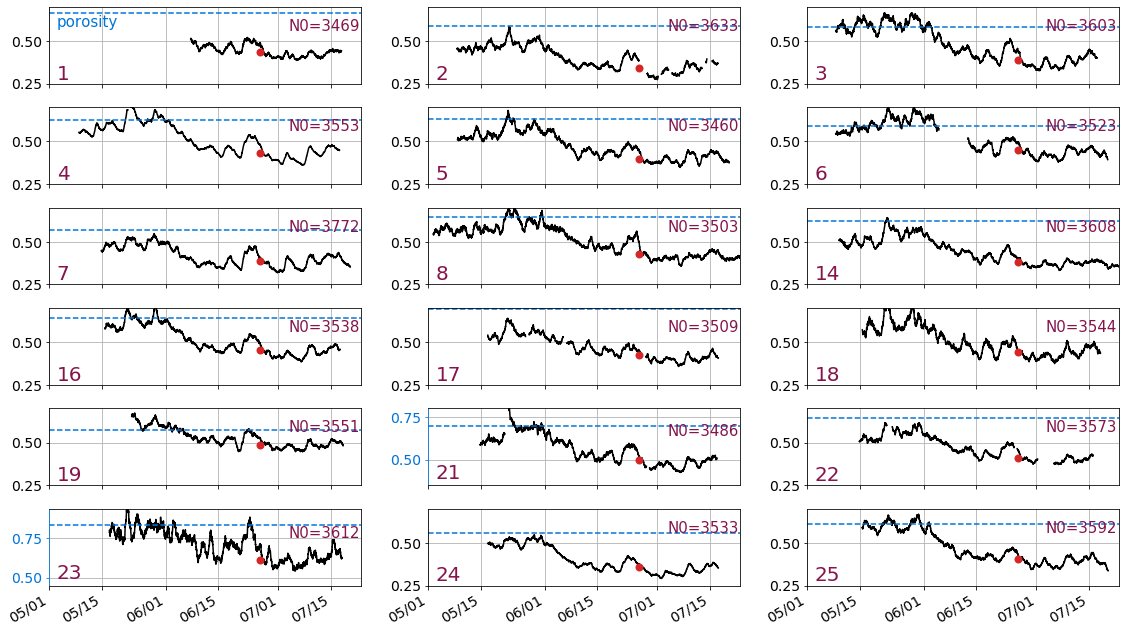

In [153]:
plt.rc('font', **{'size'   : 14})
ids = np.array(attrs[attrs.hasdata].id)
colors = plt.cm.tab20(np.linspace(0,1,len(ids)))

fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(16,9), sharex=True)
ax = ax.ravel()

for i, id in enumerate(attrs.index[attrs.hasdata]):
    plt.sca(ax[i])
    #if id==3:
    #    tmp=cs.core.n_to_theta_desilets(0.92*h24[id], n0=3400, rhob=attrs.loc[3, "bd_havg"]*1000)
    #    plt.plot(tmp.index+dt.timedelta(hours=12), tmp, color="black")
    #else:
    plt.plot(crnstheta.index+dt.timedelta(hours=12), crnstheta[id], color="black")
    ymin = 0.25
    ymax = 0.7
    if crnstheta[id].max() > 0.75:
        ymax = 0.1 + 1-attrs.loc[id, "rhob"]/2.65# np.round(crnstheta[id].max(),1)
        ymin = np.round(crnstheta[id].min(),1)-0.05
        ax[i].spines['left'].set_color("#0074D9")
        ax[i].tick_params(axis='y', colors="#0074D9")
    plt.grid()
    plt.ylim(ymin, ymax)
    #plt.title("Theta (24 hours)")
    #plt.ylabel("m3/m3")
    plt.plot(dt.datetime(2019,6,26,0,0,0), attrs.loc[id, "theta"], lw=0, marker="o", ms=8, mec="None", mfc="tab:red")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.xlim(min_dtime-dt.timedelta(hours=1), max_dtime)
    plt.axhline(y=1-attrs.loc[id, "rhob"]/2.65, linestyle="dashed", color="#0074D9")
    plt.text(dt.datetime(2019,5,3), 1.1*ymin, str(id), color="#85144b", fontsize=20)
    plt.text(crnstheta.index[-1400], 0.8*ymax, "N0=%d" % int(attrs.loc[id, "n0"]), color="#85144b", fontsize=15)
    if i==0:
        plt.text(dt.datetime(2019,5,3), 1-attrs.loc[id, "rhob"]/2.65 - 0.08, "porosity", color="#0074D9", fontsize=15)

fig.autofmt_xdate() 
plt.tight_layout()

(3400, 3800)

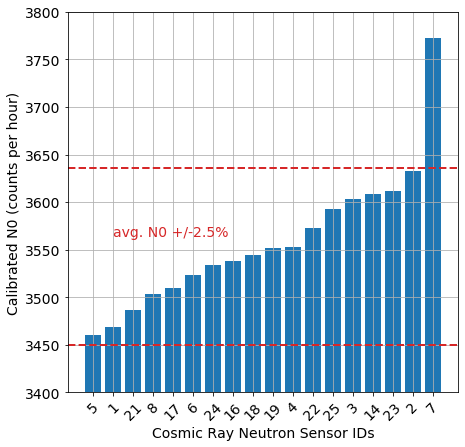

In [154]:
n0arr = np.array(attrs.n0[attrs.hasdata])
n0ids = np.array(attrs.index[attrs.hasdata])
forestcol = ["#784212"]
edgecol = ["#145a32"]
meadowcol = ["#28b463"]
#turfcol = ["#1f618d"]
legend_elements = [plt.Line2D([0], [0], color=forestcol[0], lw=6, label="forest"),
                plt.Line2D([0], [0], color=edgecol[0], lw=6, label="close to forest"),
                plt.Line2D([0], [0], color=meadowcol[0], lw=6, label="meadow")]
                #plt.Line2D([0], [0], color=turfcol[0], lw=6, label="peat")]
#n0_mean = attrs.loc[[5,17,8,24,2,16,3,4,18,25,23,7]].n0.mean()
n0_mean = attrs.n0[~(attrs.id==7)].mean()
colors = forestcol*3 + edgecol*3 + meadowcol*12
sortix = np.argsort(n0arr)
fig, ax = plt.subplots(figsize=(7,7))
xticks = np.arange(len(n0arr))
plt.bar(xticks, n0arr[sortix])#, color=colors)
plt.axhline(y=1.025*n0_mean, color="tab:red", ls="dashed", lw=2)
plt.axhline(y=0.9725*n0_mean, color="tab:red", ls="dashed", lw=2)
plt.text(1, 1.005*n0_mean, "avg. N0 +/-2.5%", color="tab:red")
plt.xticks(xticks)
plt.xlabel("Cosmic Ray Neutron Sensor IDs")
plt.ylabel("Calibrated N0 (counts per hour)")
_ = ax.set_xticklabels(n0ids[sortix], rotation=45 )
plt.grid()
plt.ylim(3400,3800)
#plt.title("Calibrated N0 - effect of vegetation?")
#_ = ax.legend(handles=legend_elements)

### One N0 for all

In [155]:
crnstheta_uniform = h24.apply(copy.deepcopy)
crnstheta_uniform48 = h48.apply(copy.deepcopy)
for id in attrs.index[attrs.hasdata]:
    crnstheta_uniform[id] = cs.core.n_to_theta_desilets(h24[id].copy(), n0=attrs.n0[~(attrs.id==7)].mean(), rhob=attrs.loc[id, "rhob"]*1000)
    crnstheta_uniform48[id] = cs.core.n_to_theta_desilets(h48[id].copy(), n0=attrs.n0[~(attrs.id==7)].mean(), rhob=attrs.loc[id, "rhob"]*1000)

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


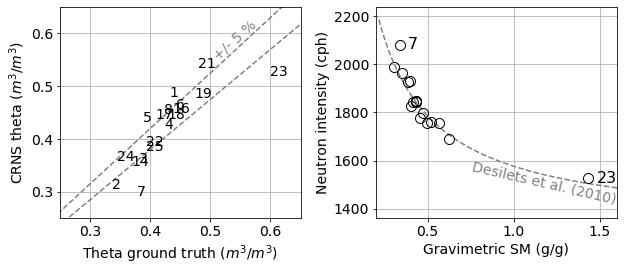

In [156]:
# Kind of validation
truth = attrs.theta[attrs.hasdata]
obscph = np.array([np.nanmean(crns20c_vegc.loc[caltimes[0]:caltimes[1], id]) for id in attrs.index[attrs.hasdata] ])
est1 = np.array([cs.core.n_to_theta_desilets(obscph[i], n0=attrs.loc[id, "n0"], rhob=attrs.loc[id, "rhob"]*1000) for i, id in enumerate(attrs.index[attrs.hasdata]) ])
est2 = np.array([cs.core.n_to_theta_desilets(obscph[i], n0=attrs.n0[~(attrs.id==7)].mean(), rhob=attrs.loc[id, "rhob"]*1000) for i, id in enumerate(attrs.index[attrs.hasdata]) ])

avgn0 = attrs.n0[~(attrs.id==7)].mean()

plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(figsize=(9,4), ncols=2)
ax = ax.ravel()

# plt.sca(ax[0])
# ax[0].set_aspect("equal")
# plt.plot([0,1], [0,1], ms=0, color="grey", ls="--")
# for i, id in enumerate(attrs.index[attrs.hasdata]):
#     plt.plot(truth[id], est1[i], marker="o", mfc="None", mec="black")
# plt.grid()
# plt.xlim(0.3, 0.7)    
# plt.ylim(0.3, 0.7)
# plt.xlabel("Theta ground truth (m3/m3)")
# plt.ylabel("CRNS theta (m3/m3)")

plt.sca(ax[0])
#ax[0].set_aspect("equal")
#plt.plot([0,1], [0,1], ms=0, color="grey", ls="--")
plt.plot([0,1], 0.95*np.array([0,1]), ms=0, color="grey", ls="--", label="+/- 5 %")
plt.plot([0,1], 1.05*np.array([0,1]), ms=0, color="grey", ls="--", label="_tmp")
#plt.plot(truth, est2, marker="o", color="black", lw=0, mfc="None")
for i, id in enumerate(attrs.index[attrs.hasdata]):
    tmp1 = np.nanmean(crns20c_vegc.loc['2019-06-25 10:00:00':'2019-06-25 18:00:00', id])
    tmp2 = np.nanmean(crns20c_vegc.loc['2019-06-26 10:00:00':'2019-06-26 18:00:00', id])
    tmptheta = cs.core.n_to_theta_desilets(np.array([tmp1,tmp2]), n0=attrs.n0[~(attrs.id==7)].mean(), 
                                           rhob=attrs.loc[id, "rhob"]*1000)
    #plt.plot([truth[id],truth[id]], [tmptheta[0], tmptheta[1]], color="black")
    plt.text(truth[id], est2[i], str(id), horizontalalignment='center', verticalalignment='center')
plt.grid()
plt.xlim(0.25, 0.65)    
plt.ylim(0.25, 0.65)
plt.xlabel("Theta ground truth ($m^3/m^3$)")
plt.ylabel("CRNS theta ($m^3/m^3$)")
plt.text(0.5, 0.55, "+/- 5 %", rotation=42, color="grey", fontsize=14)

plt.sca(ax[1])
#ax[2].set_aspect("equal")
narr = np.arange(1400,2200)
plt.plot(cs.core.n_to_theta_desilets(narr, n0=avgn0, rhob=1000.), narr, color="grey", ls="dashed")
for i, id in enumerate(attrs.index[attrs.hasdata]):
    tmp1 = np.nanmean(crns20c_vegc.loc['2019-06-25 10:00:00':'2019-06-25 18:00:00', id])
    tmp2 = np.nanmean(crns20c_vegc.loc['2019-06-26 10:00:00':'2019-06-26 18:00:00', id])
    tmptheta = cs.core.n_to_theta_desilets(np.mean([tmp1, tmp2]), n0=avgn0, rhob=1000.) 
    #plt.plot([truth[id],truth[id]], [tmptheta[0], tmptheta[1]], color="black")
    plt.plot(truth[id]/attrs.loc[id, "rhob"], np.mean([tmp1, tmp2]), ms=10, marker="o", mfc="None", mec="black")
    if id in [7, 23]:
        plt.text(truth[id]/attrs.loc[id, "rhob"]+0.05, np.mean([tmp1, tmp2]), str(id), 
                 horizontalalignment='left', verticalalignment='center', fontsize=16)
plt.xlabel("Gravimetric SM (g/g)")
plt.ylabel("Neutron intensity (cph)")
plt.grid()
plt.text(0.75, 1420, "Desilets et al. (2010)", rotation=-13, color="grey", fontsize=14)
plt.xlim(0.2, 1.6)


plt.tight_layout()

plt.savefig("n0_calibration.png", dpi=300, bbox_inches="tight")

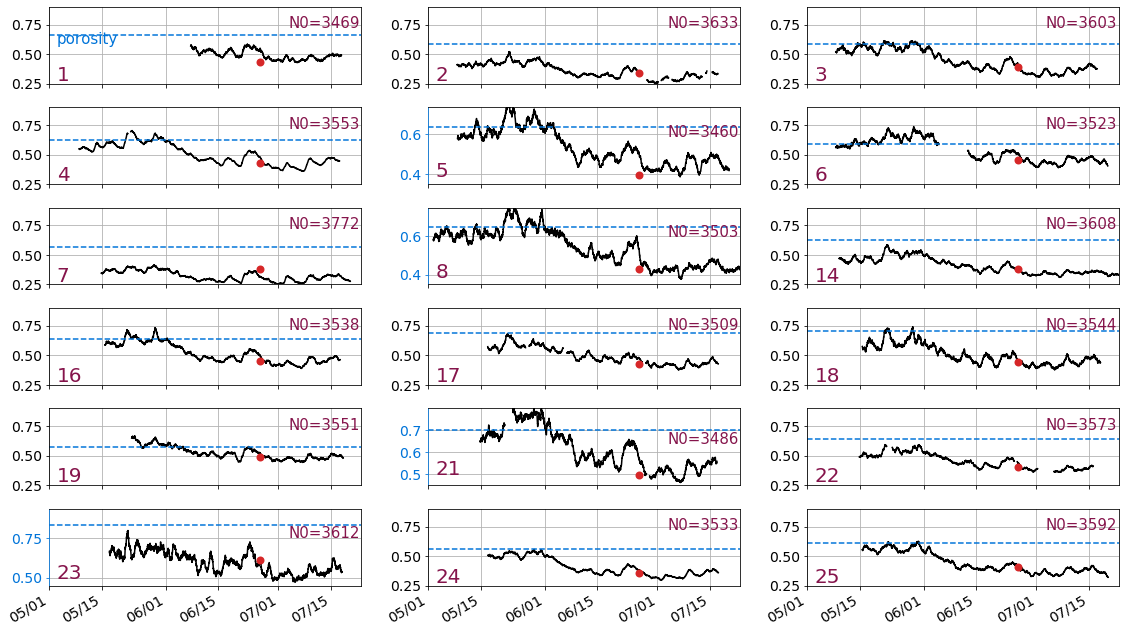

In [157]:
plt.rc('font', **{'size'   : 14})
ids = np.array(attrs[attrs.hasdata].id)
colors = plt.cm.tab20(np.linspace(0,1,len(ids)))

fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(16,9), sharex=True)
ax = ax.ravel()

for i, id in enumerate(attrs.index[attrs.hasdata]):
    plt.sca(ax[i])
    #if id==3:
    #    tmp=cs.core.n_to_theta_desilets(0.92*h24[id], n0=3400, rhob=attrs.loc[3, "bd_havg"]*1000)
    #    plt.plot(tmp.index+dt.timedelta(hours=12), tmp, color="black")
    #else:
    plt.plot(crnstheta_uniform.index+dt.timedelta(hours=12), crnstheta_uniform[id], color="black")
    ymin = 0.25
    ymax = 0.9
    if crnstheta_uniform[id].max() > 0.75:
        ymax = 0.1 + 1-attrs.loc[id, "rhob"]/2.65# np.round(crnstheta[id].max(),1)
        ymin = np.round(crnstheta_uniform[id].min(),1)-0.05
        ax[i].spines['left'].set_color("#0074D9")
        ax[i].tick_params(axis='y', colors="#0074D9")
    plt.grid()
    plt.ylim(ymin, ymax)
    #plt.title("Theta (24 hours)")
    #plt.ylabel("m3/m3")
    plt.plot(dt.datetime(2019,6,26,0,0,0), attrs.loc[id, "theta"], lw=0, marker="o", ms=8, mec="None", mfc="tab:red")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.xlim(min_dtime-dt.timedelta(hours=1), max_dtime)
    plt.axhline(y=1-attrs.loc[id, "rhob"]/2.65, linestyle="dashed", color="#0074D9")
    plt.text(dt.datetime(2019,5,3), 1.1*ymin, str(id), color="#85144b", fontsize=20)
    plt.text(crnstheta_uniform.index[-1400], 0.8*ymax, "N0=%d" % int(attrs.loc[id, "n0"]), color="#85144b", fontsize=15)
    if i==0:
        plt.text(dt.datetime(2019,5,3), 1-attrs.loc[id, "rhob"]/2.65 - 0.08, "porosity", color="#0074D9", fontsize=15)

fig.autofmt_xdate() 
plt.tight_layout()

## Construct gridded series of theta from calibrated CRNS

In [158]:
# Each CRNS provides a weight on a common grid, based on distance and footprint characteristics
allw = np.zeros((np.sum(attrs.hasdata), len(xxyy)))
for i, id in enumerate(attrs.index[attrs.hasdata]):
    dist = cs.util.distance(np.array([attrs.loc[id,"x"], attrs.loc[id,"y"]]).T, xxyy)
    w = cs.core.horizontal_weight_koehli_approx(dist)# / (2 * np.pi * dist)
    #w = cs.core.horizontal_weight_zreda2008b(dist)
    w[dist>300] = 0
    allw[i] = w

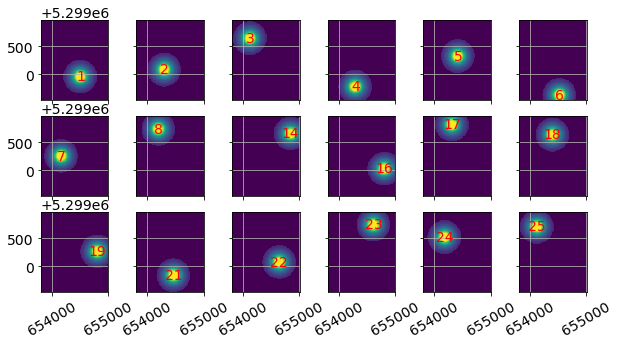

In [159]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(10,5),sharex=True, sharey=True)
ax=ax.ravel()
for i, id in enumerate(attrs.index[attrs.hasdata]):
    plt.sca(ax[i])
    ax[i].set_aspect('equal')
    p=plt.pcolormesh(xx, yy, allw[i].reshape(xx.shape), vmax=.5)
    plt.grid()
    plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="red")
    plt.xticks(rotation=30)

In [189]:
startdate = "2019-05-01"
enddate = "2019-07-22"
sli = crnstheta[startdate:enddate][attrs.index[attrs.hasdata]].resample("12H", loffset=dt.timedelta(hours=6)).mean()
vals = np.zeros((len(sli),len(xxyy)))
for i in range(len(sli)):
    tmp = np.array(sli.iloc[i]).reshape((-1,1))
    goodix = ~np.isnan(tmp).ravel()
    vals[i] = np.sum(tmp[goodix] * allw[goodix], axis=0) / allw[goodix].sum(axis=0)

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


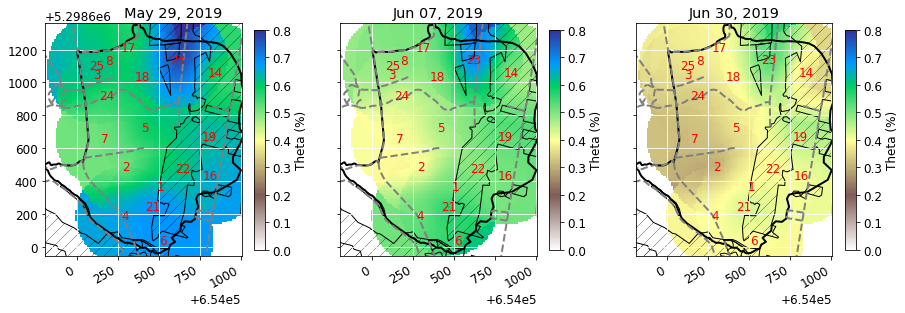

In [162]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,9), sharey=True)
#ax = ax.ravel()

wetdate = dt.datetime(2019,5,29,0,0)
mediumdate = dt.datetime(2019,6,7,0,0)
drydate = dt.datetime(2019,6,30,0,0)
ixwet = np.where(sli.index.to_pydatetime()==wetdate)[0][0]
ixmedium = np.where(sli.index.to_pydatetime()==mediumdate)[0][0]
ixdry = np.where(sli.index.to_pydatetime()==drydate)[0][0]

ax[0].set_aspect("equal")
plt.sca(ax[0])
axi=0
#quad1 = ax.imshow(vals[0].reshape(xx.shape), origin="lower", vmin=0.3, vmax=0.9, cmap=plt.cm.viridis_r)
quad1 = ax[0].pcolormesh(xx, yy, vals[ixwet].reshape(xx.shape), vmin=0.0, vmax=0.8, shading="flat", cmap=plt.cm.terrain_r)
for id in attrs.index[attrs.hasdata]:
    text_object = ax[0].annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="red")
#for road in roadscoords:
#    ax.plot(road[0], road[1], "grey", linestyle="dashed")
#ax.plot(catchmcoords[0][0], catchmcoords[0][1], color="black")
wradlib.vis.add_lines(ax[0], catborders, color='black', lw=2)
wradlib.vis.add_lines(ax[0], roads, color='grey', ls="dashed", lw=2)
for i in range(len(lut)):
    if lutkeys[i]=="forest":
        wradlib.vis.add_patches(ax[0], lut[i], hatch="//", facecolors="None")
ax[axi].ticklabel_format(axis="x", useOffset=654000)
ax[0].grid(color="white")
#tstamp = ax.set_title("")
cb = plt.colorbar(quad1, shrink=0.5)
cb.set_label("Theta (%)")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title(wetdate.strftime("             %b %d, %Y"))

ax[axi].ticklabel_format(axis="y", useOffset=5298600)

axi = 1
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
#quad1 = ax.imshow(vals[0].reshape(xx.shape), origin="lower", vmin=0.3, vmax=0.9, cmap=plt.cm.viridis_r)
quad1 = ax[axi].pcolormesh(xx, yy, vals[ixmedium].reshape(xx.shape), vmin=0.0, vmax=0.8, shading="flat", cmap=plt.cm.terrain_r)
for id in attrs.index[attrs.hasdata]:
    text_object = ax[axi].annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="red")
#for road in roadscoords:
#    ax.plot(road[0], road[1], "grey", linestyle="dashed")
#ax.plot(catchmcoords[0][0], catchmcoords[0][1], color="black")
wradlib.vis.add_lines(ax[axi], catborders, color='black', lw=2)
wradlib.vis.add_lines(ax[axi], roads, color='grey', ls="dashed", lw=2)
for i in range(len(lut)):
    if lutkeys[i]=="forest":
        wradlib.vis.add_patches(ax[axi], lut[i], hatch="//", facecolors="None")
ax[axi].ticklabel_format(axis="x", useOffset=654000)
ax[axi].grid(color="white")
#tstamp = ax.set_title("")
cb = plt.colorbar(quad1, shrink=0.5)
cb.set_label("Theta (%)")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title(mediumdate.strftime("%b %d, %Y"))


axi = 2
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
#quad1 = ax.imshow(vals[0].reshape(xx.shape), origin="lower", vmin=0.3, vmax=0.9, cmap=plt.cm.viridis_r)
quad1 = ax[axi].pcolormesh(xx, yy, vals[ixdry].reshape(xx.shape), vmin=0.0, vmax=0.8, shading="flat", cmap=plt.cm.terrain_r)
for id in attrs.index[attrs.hasdata]:
    text_object = ax[axi].annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="red")
#for road in roadscoords:
#    ax.plot(road[0], road[1], "grey", linestyle="dashed")
#ax.plot(catchmcoords[0][0], catchmcoords[0][1], color="black")
wradlib.vis.add_lines(ax[axi], catborders, color='black', lw=2)
wradlib.vis.add_lines(ax[axi], roads, color='grey', ls="dashed", lw=2)
for i in range(len(lut)):
    if lutkeys[i]=="forest":
        wradlib.vis.add_patches(ax[axi], lut[i], hatch="//", facecolors="None")
ax[axi].ticklabel_format(axis="x", useOffset=654000)
ax[axi].grid(color="white")
#tstamp = ax.set_title("")
cb = plt.colorbar(quad1, shrink=0.5)
cb.set_label("Theta (%)")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title(drydate.strftime("%b %d, %Y"))

fig.autofmt_xdate() 

plt.savefig("datapaper/mapsseries.png", dpi=300, bbox_inches="tight")

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice


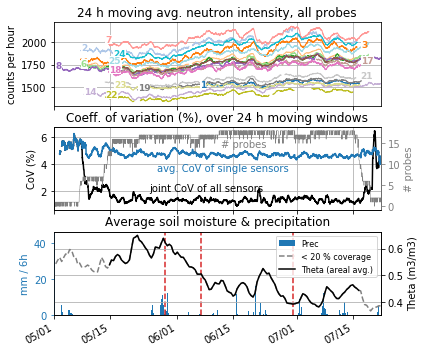

In [163]:
plt.rc('font', **{'size'   : 10})

colors = plt.cm.tab20(np.linspace(0,1,len(ids)))

fig, ax = plt.subplots(nrows=3, figsize=(6,5))

xlim = (dt.datetime(2019,5,1), dt.datetime(2019,7,22))

#plt.sca(ax[0])
#for i, id in enumerate(ids):
#    singlepl = plt.plot(crns20c.index, crns20c[id], color=colors[i], lw=0, marker=".", ms=1, mec="None")
##mpl = plt.plot(crns20c.index, crns20c[ids].mean(axis=1), color="black", label="Mean over all probes", lw=0.8)
#mpl = plt.plot(crns20c.index, crns20c["arealavg"], color="black", label="Areal avg.", lw=0.5)
#plt.grid()
#plt.title("Neutron intensity at 20 min. interval")
#ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
##plt.xlim(min_dtime-dt.timedelta(hours=1), None)
#plt.xlim(xlim)
#plt.legend(mpl+[plt.Line2D([0], [0], marker=".", color="grey", ms=3, lw=0)], ["Areal avg.", "Single probe cph"])
#plt.ylabel("counts per hour")
#plt.ylim(1000, 2500)

plt.sca(ax[0])
crns24hchst = crns20c.resample("24H").mean()
for i, id in enumerate(ids):
    tmp = crns20c[id].rolling("24H", min_periods=3*24-10).mean()
    plt.plot(tmp.index-dt.timedelta(hours=12), tmp, lw=1, color=colors[i], label=(str(id)))
    if id in [3, 17, 21]:
        tmpix = np.where(~np.isnan(tmp))[0][-1]
        shift = dt.timedelta(hours=12)
    else:
        tmpix = np.where(~np.isnan(tmp))[0][0]
        shift = -dt.timedelta(hours=12)
    plt.text(tmp.index[tmpix]+shift, np.array(tmp)[tmpix], str(id), fontsize=9, weight="bold",
             color=colors[i], bbox=dict(facecolor="white", edgecolor='None', pad=0.0))#backgroundcolor="white", bbox=0)
    #plt.plot(crns24hchst.index+dt.timedelta(hours=12), crns24hchst[id], color=colors[i])
#plt.ylim(7600, 8800)
plt.grid()
plt.title("24 h moving avg. neutron intensity, all probes", fontsize=12)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(xlim)
#plt.legend(ncol=2, loc="upper left", fontsize=12)
plt.ylabel("counts per hour")


plt.sca(ax[1])
tmp = crns20c[ids].mean(axis=1).rolling("24H").std()
tmp2 = crns20c[ids].count(axis=1)#.rolling("24H").mean()
plareal = plt.plot(crns20c.index + dt.timedelta(hours=12), arealavg24h_cov, color="black")
plsingle = plt.plot(crns20c.index + dt.timedelta(hours=12), singlecrns24h_cov_mean, color="tab:blue")
plt.xlim(ax[1].get_xlim())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.xlim(xlim)
plt.grid()
plt.title("Coeff. of variation (%), over 24 h moving windows", fontsize=12)
plt.ylabel("CoV (%)")
plt.text(dt.datetime(2019, 5, 25), 2, "joint CoV of all sensors")
plt.text(dt.datetime(2019, 5, 27), 3.5, "avg. CoV of single sensors", color="tab:blue")
ax4 = ax[1].twinx()
plnum = plt.plot(tmp2.index, tmp2, color="grey", label="# probes", lw=0.5)
plt.ylabel("# probes", color="grey")
plt.text(dt.datetime(2019, 6,12), 14, "# probes", color="grey")
ax4.spines['right'].set_color("grey")
ax4.tick_params(axis='y', colors="grey")
#plt.legend(plareal+plsingle+plnum, ["joint CoV of all sensors", "average CoV of single sensors", "# probes"],
#           ncol=1)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))


plt.sca(ax[2])
tmp = prec.depth.resample("6H", loffset=dt.timedelta(hours=3)).sum()
plprec = plt.bar(tmp.index, tmp, linewidth=0, width=0.2,  label="Precipitation (6 hrs)")
#plt.legend(loc="upper left")
#plt.grid()
plt.ylabel("mm / 6h", color="tab:blue")
ax[2].spines['left'].set_color("tab:blue")
ax[2].tick_params(axis='y', colors="tab:blue")
plt.axvline(x=wetdate, color="tab:red", ls="dashed")
plt.axvline(x=mediumdate, color="tab:red", ls="dashed")
plt.axvline(x=drydate, color="tab:red", ls="dashed")

ax2 = ax[2].twinx()
avgtheta = np.nanmean(vals, axis=1)
avgtheta[np.sum(np.isnan(vals), axis=1) > 0.2*len(xxyy)] = np.nan
lowcovpl = plt.plot(sli.index, np.nanmean(vals, axis=1), label="< 20% cvrg.", color="grey", ls="dashed")
fullcovpl = plt.plot(sli.index, avgtheta, label="Avg. theta (%)", color="black")
#ax[i].spines['left'].set_color("#0074D9")
#ax[i].tick_params(axis='y', colors="#0074D9")

#plt.plot(crns20c.index, crns20c["arealavg"], lw=0.2, color="grey", label="20 minutes")
#plt.plot(crns20c.index-dt.timedelta(hours=12), arealavg24h_mean, lw=2, color="tab:red", label="24 h moving")
#plt.xlim(ax[0].get_xlim())
#ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#plt.xlim(min_dtime-dt.timedelta(hours=1), None)
#plt.ylim(7600, 8600)
plt.xlim(xlim)
plt.grid()
#plt.legend(loc="upper right")
plt.legend([plprec.patches[0]]+lowcovpl+fullcovpl, ["Prec", "< 20 % coverage", "Theta (areal avg.)"], 
           loc="upper right", fontsize=8)
plt.title("Average soil moisture & precipitation", fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.ylabel("Theta (m3/m3)")



fig.autofmt_xdate() 

plt.tight_layout(h_pad=0.2)

plt.savefig("timeseries.png", dpi=150, bbox_inches="tight")

2019-06-06 23:20:00 0.5566679715621327
2019-05-08 01:40:00 0.40350925389081826
2019-05-14 00:00:00 0.5596613963447286
2019-05-08 06:20:00 0.5560813498119883
2019-05-08 03:40:00 0.5778655271177877
2019-06-03 00:00:00 0.6660230463926239
2019-05-14 04:40:00 0.35257161130215703
2019-05-03 00:00:00 0.5870250154672345
2019-07-20 00:00:00 0.3344988827770438
2019-07-17 02:00:00 0.47552278333080156
2019-07-14 00:20:00 0.43404300443623706
2019-07-17 17:20:00 0.451098426356913
2019-05-23 06:40:00 0.6548961877952831
2019-06-24 00:00:00 0.6407629692119589
2019-05-14 05:40:00 0.4988219331552906
2019-06-23 00:00:00 0.669362025449509
2019-07-16 21:40:00 0.3731081359156997
2019-05-15 00:20:00 0.5701701586845968


/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice


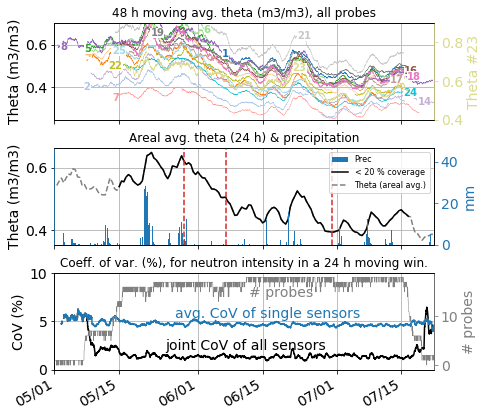

In [164]:
plt.rc('font', **{'size'   : 14})

colors = plt.cm.tab20(np.linspace(0,1,len(ids)))

fig, ax = plt.subplots(nrows=3, figsize=(7,6))

xlim = (dt.datetime(2019,5,1), dt.datetime(2019,7,22))

#plt.sca(ax[0])
#for i, id in enumerate(ids):
#    singlepl = plt.plot(crns20c.index, crns20c[id], color=colors[i], lw=0, marker=".", ms=1, mec="None")
##mpl = plt.plot(crns20c.index, crns20c[ids].mean(axis=1), color="black", label="Mean over all probes", lw=0.8)
#mpl = plt.plot(crns20c.index, crns20c["arealavg"], color="black", label="Areal avg.", lw=0.5)
#plt.grid()
#plt.title("Neutron intensity at 20 min. interval")
#ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
##plt.xlim(min_dtime-dt.timedelta(hours=1), None)
#plt.xlim(xlim)
#plt.legend(mpl+[plt.Line2D([0], [0], marker=".", color="grey", ms=3, lw=0)], ["Areal avg.", "Single probe cph"])
#plt.ylabel("counts per hour")
#plt.ylim(1000, 2500)
plstart = "2019-05-01"
plend = "2019-07-22"

labeltimes = {3:  dt.datetime(2019,5,14),
              6:  dt.datetime(2019,6,3),
              8:  dt.datetime(2019,5,3),
              14: dt.datetime(2019,7,20),
              16: crnstheta_uniform48[16].index[np.where(~np.isnan(crnstheta_uniform48[16]))[0][-1]],
              17: crnstheta_uniform48[17].index[np.where(~np.isnan(crnstheta_uniform48[17]))[0][-200]],
              18: crnstheta_uniform48[18].index[np.where(~np.isnan(crnstheta_uniform48[18]))[0][-1]],
              19: crnstheta_uniform48[19].index[np.where(~np.isnan(crnstheta_uniform48[19]))[0][0]],
              21: dt.datetime(2019,6,24),
              23: dt.datetime(2019,6,23),
              24: crnstheta_uniform48[24].index[np.where(~np.isnan(crnstheta_uniform48[24]))[0][-1]]}

plt.sca(ax[0])
ax0 = ax[0].twinx()
for i, id in enumerate(ids):
    tmp = crnstheta_uniform48[id]
    if id==23:
        plt.sca(ax0)
        ax0.plot(tmp.index-dt.timedelta(hours=24), tmp, lw=0.5, color=colors[i], label=(str(id)))
        plt.ylim(0.4,0.9)
        ax0.spines['right'].set_color(colors[i])
        ax0.tick_params(axis='y', colors=colors[i])
        plt.ylabel("Theta #23", color=colors[i])
    else:
        plt.sca(ax[0])
        plt.plot(tmp.index-dt.timedelta(hours=24), tmp, lw=0.5, color=colors[i], label=(str(id)))
    if id in labeltimes.keys():
        labeltime = labeltimes[id]
        tmpix = np.argmin(np.abs((tmp.index-labeltime).total_seconds()))
    else:
        tmpix = np.where(~np.isnan(tmp))[0][0]
        labeltime = tmp.index[tmpix]-dt.timedelta(hours=24)
    labely = np.array(tmp)[tmpix]
    plt.text(labeltime, labely, str(id), fontsize=10, weight="bold",
             color=colors[i], bbox=dict(facecolor="white", edgecolor='None', pad=0.0),
            horizontalalignment="center", verticalalignment="center")
    #plt.plot(crns24hchst.index+dt.timedelta(hours=12), crns24hchst[id], color=colors[i])
    print(labeltime, labely)
#plt.ylim(7600, 8800)
plt.grid()
plt.title("48 h moving avg. theta (m3/m3), all probes", fontsize=12)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(xlim)
#plt.legend(ncol=2, loc="upper left", fontsize=12)
plt.ylabel("Theta (m3/m3)")
plt.ylim(0.25,0.7)

axi = 1
plt.sca(ax[axi])

avgtheta = np.nanmean(vals, axis=1)
avgtheta[np.sum(np.isnan(vals), axis=1) > 0.2*len(xxyy)] = np.nan
lowcovpl = plt.plot(sli.index, np.nanmean(vals, axis=1), label="< 20% cvrg.", color="grey", ls="dashed")
fullcovpl = plt.plot(sli.index, avgtheta, label="Avg. theta (%)", color="black")
plt.ylabel("Theta (m3/m3)")
plt.grid()

ax2 = ax[axi].twinx()
tmp = prec.depth.resample("6H", loffset=dt.timedelta(hours=3)).sum()
plprec = plt.bar(tmp.index, tmp, linewidth=0, width=0.2,  label="Precipitation (6 hrs)")
#tmp = prec.depth.resample("6H", loffset=dt.timedelta(hours=3)).sum()
#plprec = plt.bar(tmp.index, tmp, linewidth=0, width=0.2,  label="Precipitation (6 hrs)")
#plt.legend(loc="upper left")
#plt.grid()
ax2.set_ylabel("mm", color="tab:blue")
ax2.spines['left'].set_color("tab:blue")
ax2.tick_params(axis='y', colors="tab:blue")
plt.axvline(x=wetdate, color="tab:red", ls="dashed")
plt.axvline(x=mediumdate, color="tab:red", ls="dashed")
plt.axvline(x=drydate, color="tab:red", ls="dashed")

plt.xlim(xlim)
plt.legend([plprec.patches[0]]+fullcovpl+lowcovpl, ["Prec", "< 20 % coverage", "Theta (areal avg.)"], 
           loc="upper right", fontsize=8)
plt.title("Areal avg. theta (24 h) & precipitation", fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

axi = 2
plt.sca(ax[axi])
tmp = crns20c[ids].mean(axis=1).rolling("24H").std()
tmp2 = crns20c[ids].count(axis=1)#.rolling("24H").mean()
plareal = plt.plot(crns20c.index + dt.timedelta(hours=12), arealavg24h_cov, color="black")
plsingle = plt.plot(crns20c.index + dt.timedelta(hours=12), singlecrns24h_cov_mean, color="tab:blue")
plt.xlim(ax[1].get_xlim())
ax[axi].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.xlim(xlim)
plt.ylim(0,10)
plt.grid()
plt.title("Coeff. of var. (%), for neutron intensity in a 24 h moving win.", fontsize=12)
plt.ylabel("CoV (%)")
plt.text(dt.datetime(2019, 5, 25), 2, "joint CoV of all sensors")
plt.text(dt.datetime(2019, 5, 27), 5.3, "avg. CoV of single sensors", color="tab:blue")
ax4 = ax[axi].twinx()
plnum = plt.plot(tmp2.index, tmp2, color="grey", label="# probes", lw=0.5)
plt.ylabel("# probes", color="grey")
plt.text(dt.datetime(2019, 6,12), 14, "# probes", color="grey")
ax4.spines['right'].set_color("grey")
ax4.tick_params(axis='y', colors="grey")
#plt.legend(plareal+plsingle+plnum, ["joint CoV of all sensors", "average CoV of single sensors", "# probes"],
#           ncol=1)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

fig.autofmt_xdate() 

plt.tight_layout(h_pad=0.2)

plt.savefig("timeseries.png", dpi=150, bbox_inches="tight")

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice


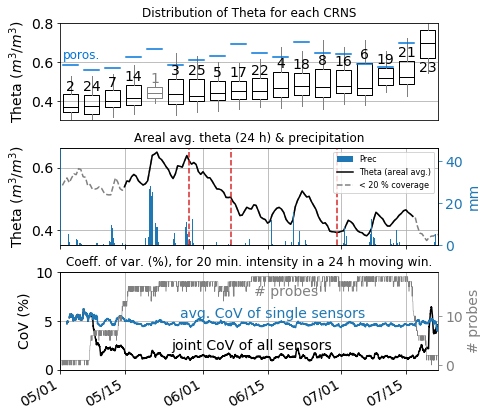

In [165]:
plt.rc('font', **{'size'   : 14})

colors = plt.cm.tab20(np.linspace(0,1,len(ids)))

fig, ax = plt.subplots(nrows=3, figsize=(7,6))

xlim = (dt.datetime(2019,5,1), dt.datetime(2019,7,22))

#plt.sca(ax[0])
#for i, id in enumerate(ids):
#    singlepl = plt.plot(crns20c.index, crns20c[id], color=colors[i], lw=0, marker=".", ms=1, mec="None")
##mpl = plt.plot(crns20c.index, crns20c[ids].mean(axis=1), color="black", label="Mean over all probes", lw=0.8)
#mpl = plt.plot(crns20c.index, crns20c["arealavg"], color="black", label="Areal avg.", lw=0.5)
#plt.grid()
#plt.title("Neutron intensity at 20 min. interval")
#ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
##plt.xlim(min_dtime-dt.timedelta(hours=1), None)
#plt.xlim(xlim)
#plt.legend(mpl+[plt.Line2D([0], [0], marker=".", color="grey", ms=3, lw=0)], ["Areal avg.", "Single probe cph"])
#plt.ylabel("counts per hour")
#plt.ylim(1000, 2500)
plstart = "2019-05-01"
plend = "2019-07-22"

plt.sca(ax[0])
period = "2019-05-22", "2019-07-15"
whichdata = crnstheta.copy()
sortix = np.argsort(np.nanmean(whichdata[period[0]:period[1]][attrs.index[attrs.hasdata]], axis=0))
for i, ix in enumerate(sortix):
    id = attrs.index[attrs.hasdata][ix]
    boxdata = whichdata[period[0]:period[1]][id][~np.isnan(whichdata[id])]
    if id==1:
        color="grey"
    else:
        color="black"
    bp = plt.boxplot(boxdata, positions=[i], 
                showfliers=False, whis=True, showcaps=False, widths=[0.7], labels=[str(id)], 
                boxprops=dict(color=color), medianprops=dict(color=color), capprops=dict(color=color),
                whiskerprops=dict(color="grey"))
    if id==23:
        ypos = np.quantile(boxdata, 0.25)-0.05
    else:
        ypos = np.quantile(boxdata, 0.75)+0.04
    porx = bp["medians"][0].get_data()[0]
    pory = np.repeat(1-attrs.loc[id, "rhob"]/2.65, 2)
    plt.plot(porx, pory, color="#0074D9")
    plt.text(i, ypos, str(id), horizontalalignment="center", verticalalignment="center", color=color)
    if i==0:
        plt.text(porx[0], pory[0]+0.05, "poros.", fontsize=12,
                 horizontalalignment="left", verticalalignment="center", color="#0074D9")
plt.grid()
plt.ylabel("Theta ($m^3$/$m^3$)")
plt.ylim(0.3, 0.8)
plt.xticks([])
plt.title("Distribution of Theta for each CRNS", fontsize=12)

axi = 1
plt.sca(ax[axi])

avgtheta = np.nanmean(vals, axis=1)
avgtheta[np.sum(np.isnan(vals), axis=1) > 0.2*len(xxyy)] = np.nan
lowcovpl = plt.plot(sli.index, np.nanmean(vals, axis=1), label="< 20% cvrg.", color="grey", ls="dashed")
fullcovpl = plt.plot(sli.index, avgtheta, label="Avg. theta (%)", color="black")
plt.ylabel("Theta ($m^3$/$m^3$)")
plt.grid()

ax2 = ax[axi].twinx()
tmp = prec.depth.resample("6H", loffset=dt.timedelta(hours=3)).sum()
plprec = plt.bar(tmp.index, tmp, linewidth=0, width=0.2,  label="Precipitation (6 hrs)")
#tmp = prec.depth.resample("6H", loffset=dt.timedelta(hours=3)).sum()
#plprec = plt.bar(tmp.index, tmp, linewidth=0, width=0.2,  label="Precipitation (6 hrs)")
#plt.legend(loc="upper left")
#plt.grid()
ax2.set_ylabel("mm", color="tab:blue")
ax2.spines['left'].set_color("tab:blue")
ax2.tick_params(axis='y', colors="tab:blue")
plt.axvline(x=wetdate, color="tab:red", ls="dashed")
plt.axvline(x=mediumdate, color="tab:red", ls="dashed")
plt.axvline(x=drydate, color="tab:red", ls="dashed")

plt.xlim(xlim)
plt.legend([plprec.patches[0]]+fullcovpl+lowcovpl, ["Prec", "Theta (areal avg.)", "< 20 % coverage"], 
           loc="upper right", fontsize=8)
plt.title("Areal avg. theta (24 h) & precipitation", fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

axi = 2
plt.sca(ax[axi])
tmp = crns20c[ids].mean(axis=1).rolling("24H").std()
tmp2 = crns20c[ids].count(axis=1)#.rolling("24H").mean()
plareal = plt.plot(crns20c.index + dt.timedelta(hours=12), arealavg24h_cov, color="black")
plsingle = plt.plot(crns20c.index + dt.timedelta(hours=12), singlecrns24h_cov_mean, color="tab:blue")
plt.xlim(ax[1].get_xlim())
ax[axi].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.xlim(xlim)
plt.ylim(0,10)
plt.grid()
plt.title("Coeff. of var. (%), for 20 min. intensity in a 24 h moving win.", fontsize=12)
plt.ylabel("CoV (%)")
plt.text(dt.datetime(2019, 5, 25), 2, "joint CoV of all sensors")
plt.text(dt.datetime(2019, 5, 27), 5.3, "avg. CoV of single sensors", color="tab:blue")
ax4 = ax[axi].twinx()
plnum = plt.plot(tmp2.index, tmp2, color="grey", label="# probes", lw=0.5)
plt.ylabel("# probes", color="grey")
plt.text(dt.datetime(2019, 6,12), 14, "# probes", color="grey")
ax4.spines['right'].set_color("grey")
ax4.tick_params(axis='y', colors="grey")
#plt.legend(plareal+plsingle+plnum, ["joint CoV of all sensors", "average CoV of single sensors", "# probes"],
#           ncol=1)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

fig.autofmt_xdate() 

plt.tight_layout(h_pad=0.2)

plt.savefig("timeseries2.png", dpi=150, bbox_inches="tight")

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice


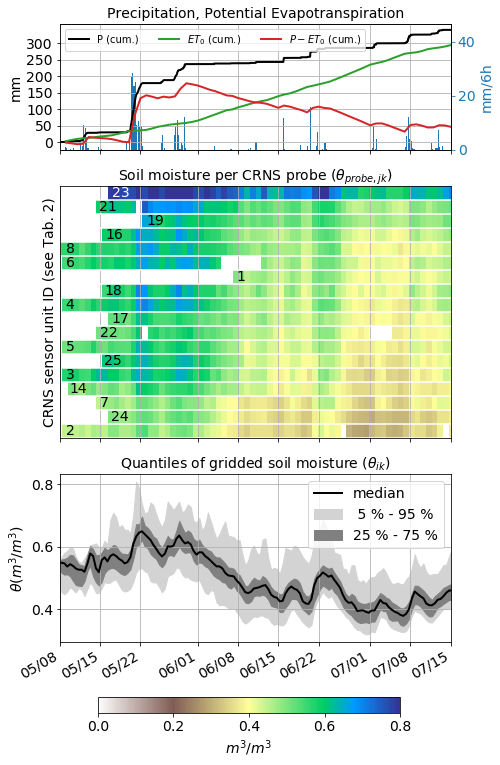

In [218]:
plt.rc('font', **{'size'   : 14})

colors = plt.cm.tab20(np.linspace(0,1,len(ids)))

#fig, ax = plt.subplots(nrows=3, figsize=(7,9), sharex=True)
fig = plt.figure(figsize=(7, 11))
gs = gridspec.GridSpec(3, 1, height_ratios=[1.5, 3, 2]) 

xlim = (dt.datetime(2019,5,8), dt.datetime(2019,7,15))

plstart = xlim[0].strftime("%Y-%m-%d")
plend = xlim[1].strftime("%Y-%m-%d")

axi=0
ax = plt.subplot(gs[axi])
plt.sca(ax)
plt.title("Precipitation, Potential Evapotranspiration", fontsize=14)
#tmp = prec.depth.resample("6H", loffset=dt.timedelta(hours=3)).sum()
#plprec = plt.bar(tmp.index, tmp, linewidth=0, width=0.2,  label="Precipitation (6 hrs)")
plprec = plt.plot(prec[plstart:plend].index, prec[plstart:plend].depth.cumsum(), color="black", lw=2, label="P (cum.)")
tmpeto = eto_pm[plstart:plend].resample("24H", loffset=dt.timedelta(hours=24)).sum()
plt.plot(tmpeto.index, tmpeto.cumsum(), color="tab:green", lw=2, label="$ET_0$ (cum.)")
balance = prec[plstart:plend].depth.resample("24H", loffset=dt.timedelta(hours=24)).sum() \
          - eto_pm[plstart:plend].resample("24H", loffset=dt.timedelta(hours=24)).sum()
plt.plot(balance.index, balance.cumsum(), linewidth=2, color="tab:red",  label="$P - ET_0$ (cum.)")
plt.ylabel("mm")
#plt.axvline(x=wetdate, color="tab:red", ls="dashed")
#plt.axvline(x=mediumdate, color="tab:red", ls="dashed")
#plt.axvline(x=drydate, color="tab:red", ls="dashed")
plt.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(xlim)
plt.legend(loc="upper left", ncol=3, fontsize=10)
plt.yticks(np.arange(0, 350, 50))

ax2 = ax.twinx()
tmp = prec.depth.resample("6H", loffset=dt.timedelta(hours=3)).sum()
plprec = plt.bar(tmp.index, tmp, linewidth=0, width=0.2, label="Precipitation (6 hrs)")
ax2.set_ylabel("mm/6h", color="tab:blue")
ax2.spines['left'].set_color("tab:blue")
ax2.tick_params(axis='y', colors="tab:blue")

ax.set_zorder(ax2.get_zorder()+1) # put ax in front of ax2
ax.patch.set_visible(False) # hide the 'canvas'

axi = 2
ax = plt.subplot(gs[axi])
plt.sca(ax)
plt.title(r"Quantiles of gridded soil moisture ($\theta_{ik}$)", fontsize=14)
avgtheta = np.nanmean(vals, axis=1)
avgtheta[np.sum(np.isnan(vals), axis=1) > 0.2*len(xxyy)] = np.nan
#lowcovpl = plt.plot(sli.index, np.nanmean(vals, axis=1), label="< 20% cvrg.", color="grey", ls="dashed")
#fullcovpl = plt.plot(sli.index, avgtheta, label="Avg. theta (%)", color="black")
#lowcovpl = plt.plot(sli.index, np.nanmean(vals, axis=1), label="< 20% cvrg.", color="grey", ls="dashed")
qu1090 = plt.fill_between(sli.index, np.nanquantile(vals, 0.05, axis=1), np.nanquantile(vals, 0.95, axis=1),
                            label=" 5 % - 95 %", color="lightgrey")
qu1090 = plt.fill_between(sli.index, np.nanquantile(vals, 0.25, axis=1), np.nanquantile(vals, 0.75, axis=1),
                            label="25 % - 75 %", color="grey")
qu1090 = plt.plot(sli.index, np.nanmedian(vals, axis=1), label="median", color="black", lw=2)
plt.xlim(xlim)

plt.ylabel(r"$\theta (m^3$/$m^3)$")
plt.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.legend()

axi = 1
ax = plt.subplot(gs[axi])
plt.sca(ax)
plt.title(r"Soil moisture per CRNS probe ($\theta_{probe,jk}$)", fontsize=14)
sortix = np.argsort(np.array(crnstheta.loc["2019-06-08":"2019-07-01", ids].mean()))
tmp = crnstheta[ids].iloc[:,sortix].resample("24H", loffset=dt.timedelta(hours=12)).mean()
x_lims = tmp.index[0], tmp.index[-1]
x_lims = mdates.date2num(x_lims)
pm = plt.imshow(tmp.T, extent = [x_lims[0], x_lims[1],  0, len(ids)], aspect="auto", origin="lower",
           cmap=plt.cm.terrain_r, vmin=0, vmax=0.8)

#ax.xaxis_date()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.grid()
for i, id in enumerate(ids[sortix]):
    tmpix = np.where(~np.isnan(crnstheta[id]))[0][0]
    labeltime = crnstheta.index[tmpix]#+dt.timedelta(hours=24)
    labeltime = np.max([labeltime, xlim[0]+dt.timedelta(hours=12)])
    #print(id, labeltime)
    if id==23:
        textcolor="white"
    else:
        textcolor="black"
    plt.text(labeltime+dt.timedelta(hours=12), i+0.5, str(id), color=textcolor, horizontalalignment="left", verticalalignment="center")
    plt.hlines(i, xmin=dt.datetime(2019,4,1), xmax=dt.datetime(2019,8,1), color="white")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.get_yaxis().set_ticks([])
plt.ylabel("CRNS sensor unit ID (see Tab. 2)")
plt.xlim(xlim)
fig.autofmt_xdate()

fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.2, 0.01, 0.6, 0.02])
cb = plt.colorbar(pm, orientation="horizontal", cax=cbar_ax)#use_gridspec=False, ax=ax)
cb.set_label("$m^3/m^3$")

#plt.tight_layout(h_pad=0.2)
#plt.tight_layout()



plt.savefig("datapaper/timeseries.png", dpi=150, bbox_inches="tight")

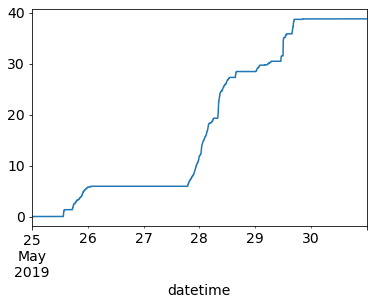

In [226]:
meteo["2019-05-25":"2019-05-30"].precip.cumsum().plot()

In [241]:
np.nanmin(np.nanquantile(vals[:-10], 0.95, axis=1))

0.47901627921169887

### Export spatiotemporal data as netcdf using xarray

In [167]:
ds_theta = xarray.Dataset(data_vars={'theta': (('datetime', 'y', 'x'),
                                               vals.reshape((-1, xx.shape[0], xx.shape[1])))},
                          coords={'x': xs, 'y':ys, 'datetime': sli.index},
                          attrs={"epsg": "32632",
                                 "unit_theta":"m3/m3",
                                 "unit_coords":"meters",
                                 "tz":"UTC",
                                 "timeref":"end_of_interval",
                                 "starttime": sli.index[0].to_pydatetime().isoformat(),
                                 "endtime": sli.index[-1].to_pydatetime().isoformat()})

In [168]:
ds_theta.to_netcdf("/home/maik/b2drop/cosmicsense/inbox/fendt/products/mc/theta_from_cph_grids.v0_1.nc",
                  encoding={"theta":{'zlib': True, 'complevel': 9}})

### Comparision with rover data

In [169]:
rvdates = ["190514", "190515", "190516", "190522", "190604", "190605","190606", "20190626", "20190627"]
fpath_per_inst = {"ufz": "/home/maik/b2drop/cosmicsense/inbox/fendt/rover/UFZ/processed/Fendt-%s.csv",
                  "fzj": "/home/maik/b2drop/cosmicsense/inbox/fendt/rover/FZJ/Processed/fzjrover-%s.csv"}
rvs = {}
for key in rvdates:
    print("Reading %s" % key)
    for inst in ["ufz", "fzj"]
    f_rover = "/home/maik/b2drop/cosmicsense/inbox/fendt/rover/UFZ/processed/Fendt-%s.csv" % key
    if len(key) > 6:
        key = key[2:]
    rvs[key] = pd.read_csv(f_rover, sep=",")
    rvs[key]["Date Time(UTC)"] = pd.to_datetime(rvs[key]["Date Time(UTC)"], format="%Y-%m-%d %H:%M:%S")
    rvs[key] = rvs[key].set_index("Date Time(UTC)")
    rvs[key]["hasloc"] = ~np.isnan(rvs[key].LongDec)
    rvs[key]["x"] = np.nan
    rvs[key]["y"] = np.nan
    rovxy = wradlib.georef.reproject(rvs[key].LongDec[rvs[key]["hasloc"]], 
                                     rvs[key].LatDec[rvs[key]["hasloc"]],
                                     projection_target=utm32n)
    rvs[key].loc[rvs[key]["hasloc"],"x"], rvs[key].loc[rvs[key]["hasloc"],"y"] = rovxy

Reading 190514
Reading 190515
Reading 190522
Reading 190604
Reading 190605
Reading 190606
Reading 20190626
Reading 20190627


In [267]:
rvdates = ["190514", "190515", "190516", "190522", "190604", "190605","190606", "20190626", "20190627"]
fpath_per_inst = {"ufz": "/home/maik/b2drop/cosmicsense/inbox/fendt/rover/UFZ/processed/Fendt-%s.csv",
                  "fzj": "/home/maik/b2drop/cosmicsense/inbox/fendt/rover/FZJ/Processed/fzjrover-%s.csv"}
rvs = {}
for key in rvdates:
    print("Reading %s" % key)
    for inst in ["ufz", "fzj"]:
        f_rover = fpath_per_inst[inst] % key
        if len(key) > 6:
            key = key[2:]
        try:
            rvs[key+inst] = pd.read_csv(f_rover, sep=",")
        except:
            continue
        print("\t %s available" % inst)
        rvs[key+inst]["Date Time(UTC)"] = pd.to_datetime(rvs[key+inst]["Date Time(UTC)"],
                                                         format="%Y-%m-%d %H:%M:%S")
        rvs[key+inst] = rvs[key+inst].set_index("Date Time(UTC)")
        rvs[key+inst]["hasloc"] = ~np.isnan(rvs[key+inst].LongDec)
        rvs[key+inst]["x"] = np.nan
        rvs[key+inst]["y"] = np.nan
        rovxy = wradlib.georef.reproject(rvs[key+inst].LongDec[rvs[key+inst]["hasloc"]], 
                                         rvs[key+inst].LatDec[rvs[key+inst]["hasloc"]],
                                         projection_target=utm32n)
        rvs[key+inst].loc[rvs[key+inst]["hasloc"],"x"], rvs[key+inst].loc[rvs[key+inst]["hasloc"],"y"] = rovxy

Reading 190514
	 ufz available
	 fzj available
Reading 190515
	 ufz available
	 fzj available
Reading 190516
	 fzj available
Reading 190522
	 ufz available
Reading 190604
	 ufz available
	 fzj available
Reading 190605
	 ufz available
	 fzj available
Reading 190606
	 ufz available
Reading 20190626
	 ufz available
Reading 20190627
	 ufz available


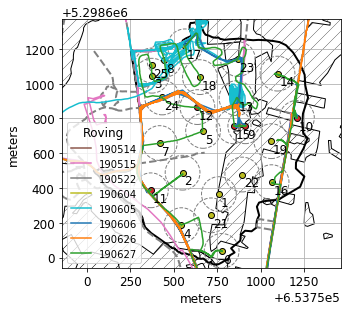

In [170]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(figsize=(5,5))
ax.set_aspect("equal")
#for locid in locs.index:
#    plt.plot(locs.loc[locid].x, locs.loc[locid].y, linewidth=0, marker="o", markersize=6, mfc="white", mec="tab:blue")

for id in attrs.index:
    if attrs.loc[id].hasdata:
        mfc = "tab:olive"
        mec = "black"
    else:
        mfc="tab:red"
        mec = "black"
    #matplotlib.patches.Circle(xy, radius=5, **kwargs)
    circle = plt.Circle((attrs.loc[id].x, attrs.loc[id].y), 100, ls="dashed", facecolor="None", edgecolor="grey")
    ax.add_artist(circle)
    plt.plot(attrs.loc[id].x, attrs.loc[id].y, linewidth=3, marker="o", markersize=6, mfc=mfc, mec=mec)
    plt.annotate(str(id), xy=(attrs.loc[id,"x"]+10, attrs.loc[id,"y"]-10), ha='left', va='top', color="black", fontsize=12)
wradlib.vis.add_lines(ax, catborders, color='black', lw=2)
wradlib.vis.add_lines(ax, roads, color='grey', ls="dashed", lw=2)
#plt.plot(xx, yy, linewidth=0, marker="o", ms=1, mfc="grey", mec="None")
#plt.plot(soilnetxy[:,0], soilnetxy[:,1], linewidth=0, marker="o", ms=3, mfc="None", mec="black")
for i in range(len(lut)):
    if lutkeys[i]=="forest":
        wradlib.vis.add_patches(ax, lut[i], hatch="//", facecolors="None")

#rvcolors = plt.cm.se
for key in rvs.keys():        
    plt.plot(rvs[key].x, rvs[key].y, label=key)
plt.legend(fontsize=10, title="Roving")
    
plt.xlim(bboxxy[0][0]-200, bboxxy[0][1]+200)
plt.ylim(bboxxy[1][0], bboxxy[1][1])
plt.grid()
ax.ticklabel_format(axis="x", useOffset=653750)
ax.ticklabel_format(axis="y", useOffset=5298600)
plt.xlabel("meters")
plt.ylabel("meters")

#legend_elements = [plt.Line2D([0], [0], marker="o", ms=6,  mec="black", mfc="tab:olive", lw=0, label="CRNS"),
#                   plt.Line2D([0], [0], marker="o",  ms=6, mec="black", mfc="tab:red", lw=0, label="CRNS (n.a.)"),
#                plt.Line2D([0], [0], marker="o", ms=4,  mec="tab:blue", mfc="white", lw=0, label="Ground truth"),
#                plt.Line2D([0], [0], marker="o", ms=3,  mec="black", mfc="None", lw=0, label="SoilNet"),
#                plt.Line2D([0], [0], lw=6, color="tab:green", label="Forest")]
#_ = ax.legend(handles=legend_elements, fontsize=8)#, loc="lower left")

plt.savefig("overviewmap_roving.png", dpi=300, bbox_inches="tight")


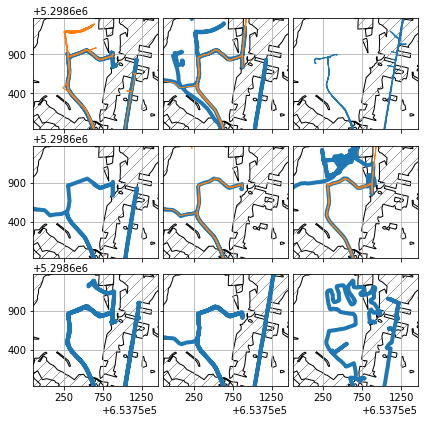

In [280]:
plt.rc('font', **{'size'   : 10})
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(6,6), sharex=True, sharey=True)
ax = ax.ravel()

# for locid in locs.index:
#     plt.plot(locs.loc[locid].x, locs.loc[locid].y, linewidth=0, marker="o", markersize=6, mfc="white", mec="tab:blue")

# for id in attrs.index:
#     if attrs.loc[id].hasdata:
#         mfc = "tab:olive"
#         mec = "black"
#     else:
#         mfc="tab:red"
#         mec = "black"
#     #matplotlib.patches.Circle(xy, radius=5, **kwargs)
#     circle = plt.Circle((attrs.loc[id].x, attrs.loc[id].y), 100, ls="dashed", facecolor="None", edgecolor="grey")
#     ax.add_artist(circle)
#     plt.plot(attrs.loc[id].x, attrs.loc[id].y, linewidth=3, marker="o", markersize=6, mfc=mfc, mec=mec)
#     plt.annotate(str(id), xy=(attrs.loc[id,"x"]+10, attrs.loc[id,"y"]-10), ha='left', va='top', color="black", fontsize=12)
# wradlib.vis.add_lines(ax, catborders, color='black', lw=2)
# wradlib.vis.add_lines(ax, roads, color='grey', ls="dashed", lw=2)
# #plt.plot(xx, yy, linewidth=0, marker="o", ms=1, mfc="grey", mec="None")
# #plt.plot(soilnetxy[:,0], soilnetxy[:,1], linewidth=0, marker="o", ms=3, mfc="None", mec="black")
# for i in range(len(lut)):
#     if lutkeys[i]=="forest":
#         wradlib.vis.add_patches(ax, lut[i], hatch="//", facecolors="None")

#rvcolors = plt.cm.se
for i, key in enumerate(rvdates):
    plt.sca(ax[i])
    ax[i].set_aspect("equal")
    for j in range(len(lut)):
        if lutkeys[j]=="forest":
            wradlib.vis.add_patches(ax[i], lut[j], hatch="//", facecolors="None")
    if len(key) > 6:
        key = key[2:]
    try:
        plt.plot(rvs[key+"ufz"].x, rvs[key+"ufz"].y, label=key+"(UFZ)", lw=4)
    except:
        pass
    try:
        plt.plot(rvs[key+"fzj"].x, rvs[key+"fzj"].y, label=key+"(FZJ)", lw=1)
    except:
        pass  
    #plt.legend(fontsize=10, title="Roving")
    plt.xlim(bboxxy[0][0]-200, bboxxy[0][1]+200)
    plt.ylim(bboxxy[1][0], bboxxy[1][1])
    plt.grid()
    ax[i].ticklabel_format(axis="x", useOffset=653750)
    ax[i].ticklabel_format(axis="y", useOffset=5298600)
    #plt.xlabel("meters")
    #plt.ylabel("meters")
    #plt.ticklabel_format()
plt.tight_layout(h_pad=0.1, w_pad=0.1)

#legend_elements = [plt.Line2D([0], [0], marker="o", ms=6,  mec="black", mfc="tab:olive", lw=0, label="CRNS"),
#                   plt.Line2D([0], [0], marker="o",  ms=6, mec="black", mfc="tab:red", lw=0, label="CRNS (n.a.)"),
#                plt.Line2D([0], [0], marker="o", ms=4,  mec="tab:blue", mfc="white", lw=0, label="Ground truth"),
#                plt.Line2D([0], [0], marker="o", ms=3,  mec="black", mfc="None", lw=0, label="SoilNet"),
#                plt.Line2D([0], [0], lw=6, color="tab:green", label="Forest")]
#_ = ax.legend(handles=legend_elements, fontsize=8)#, loc="lower left")

plt.savefig("datapaper/overviewmap_roving.png", dpi=300, bbox_inches="tight")


In [171]:
tmp = np.array(crns20c_vegc.iloc[:,0:-1][rvs["190514"].index[0]:rvs["190514"].index[-1]].mean())

In [172]:
crns20c_vegc[rvs["190514"].index[0]:rvs["190514"].index[-1]].mean()

1                   NaN
2           1915.484913
3           1777.136526
4           1747.184510
5           1725.391282
6           1750.128675
7           1996.750762
8           1711.432154
14          1844.104186
16          1738.565226
17                  NaN
18          1686.276734
19                  NaN
21          1620.146011
22          1772.459744
23                  NaN
24                  NaN
25          1770.546118
arealavg    1683.655712
dtype: float64

In [173]:
#tmp = np.array(sli.iloc[i]).reshape((-1,1))
goodix = ~np.isnan(tmp).ravel()
ref = np.sum(tmp[goodix] * allw[goodix], axis=0) / allw[goodix].sum(axis=0)

ValueError: operands could not be broadcast together with shapes (13,) (13,17303) 

In [ ]:
sli = crnstheta[startdate:enddate][attrs.index[attrs.hasdata]].resample("12H").mean()
vals = np.zeros((len(sli),len(xxyy)))
for i in range(len(sli)):
    tmp = np.array(sli.iloc[i]).reshape((-1,1))
    goodix = ~np.isnan(tmp).ravel()
    vals[i] = np.sum(tmp[goodix] * allw[goodix], axis=0) / allw[goodix].sum(axis=0)